In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import yaml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [2]:
# load yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    DATA_PATH = config.get("data_path")
    if DATA_PATH is None:
        print("ERROR: No data path provided")
    USE_DRIVE = bool(config.get("use_drive", False))

In [3]:
# load from drive if requested
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
team_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "team_statistics.csv"))
team_statistics_df.head()

,gameId,gameDate,teamCity,teamName,teamId,opponentTeamCity,opponentTeamName,opponentTeamId,home,win,...,freeThrowsAttempted,freeThrowsMade,freeThrowsPercentage,reboundsDefensive,reboundsOffensive,reboundsTotal,foulsPersonal,turnovers,plusMinusPoints,numMinutes
0,22401058,2025-03-26 22:00:00,Boston,Celtics,1610612738,Phoenix,Suns,1610612756,0,1,...,22.0,20.0,0.909,37.0,11.0,48.0,18.0,10.0,30.0,240.0
1,22401058,2025-03-26 22:00:00,Phoenix,Suns,1610612756,Boston,Celtics,1610612738,1,0,...,21.0,17.0,0.810,27.0,11.0,38.0,18.0,13.0,-30.0,240.0
2,22401057,2025-03-26 21:00:00,Denver,Nuggets,1610612743,Milwaukee,Bucks,1610612749,1,1,...,22.0,13.0,0.591,38.0,8.0,46.0,12.0,9.0,10.0,240.0
3,22401057,2025-03-26 21:00:00,Milwaukee,Bucks,1610612749,Denver,Nuggets,1610612743,0,0,...,13.0,9.0,0.692,31.0,8.0,39.0,14.0,11.0,-10.0,240.0
4,22401054,2025-03-26 19:30:00,Brooklyn,Nets,1610612751,Toronto,Raptors,1610612761,1,0,...,19.0,16.0,0.842,33.0,10.0,43.0,21.0,19.0,-30.0,240.0


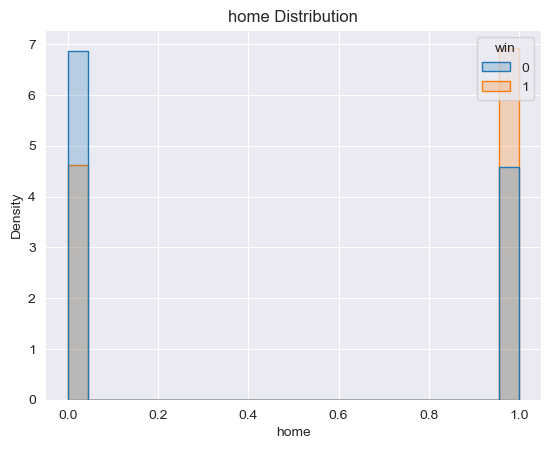

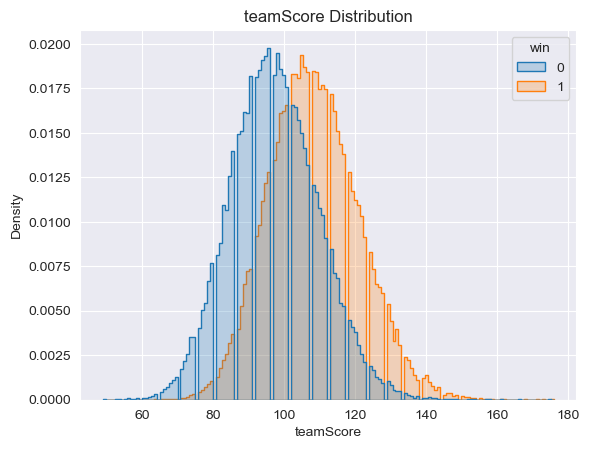

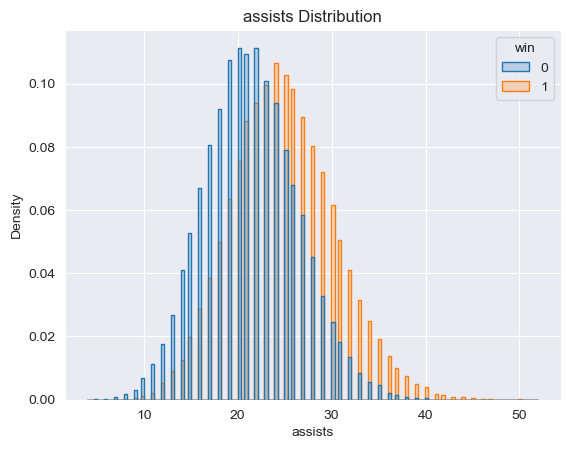

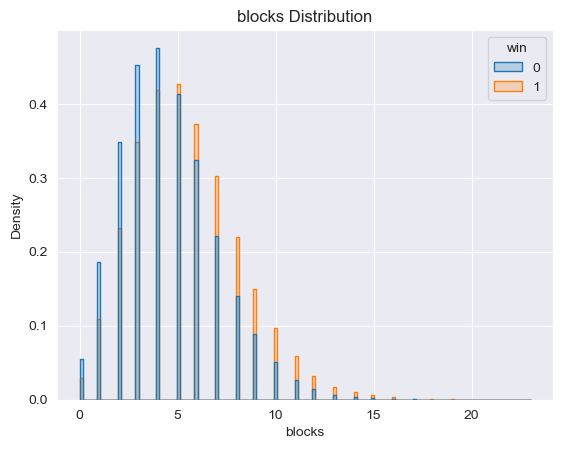

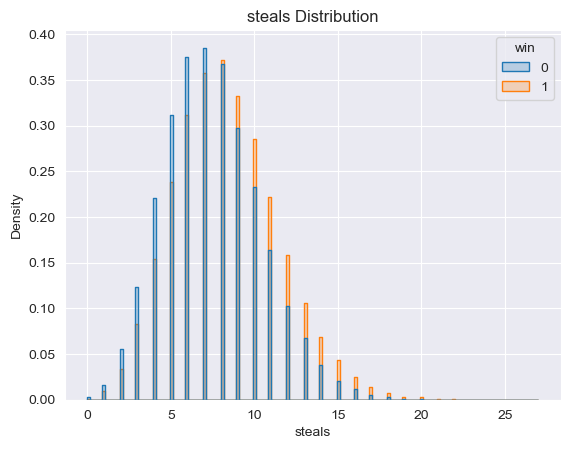

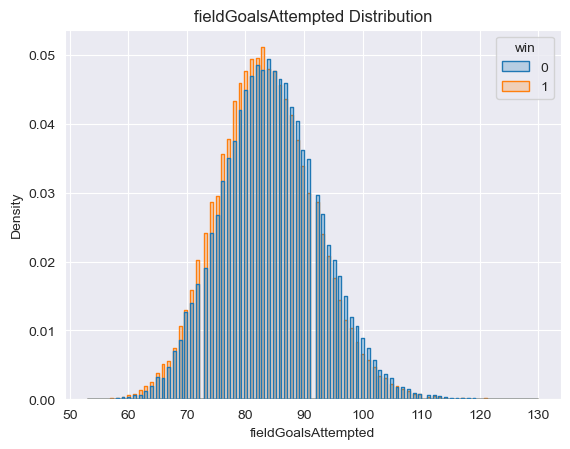

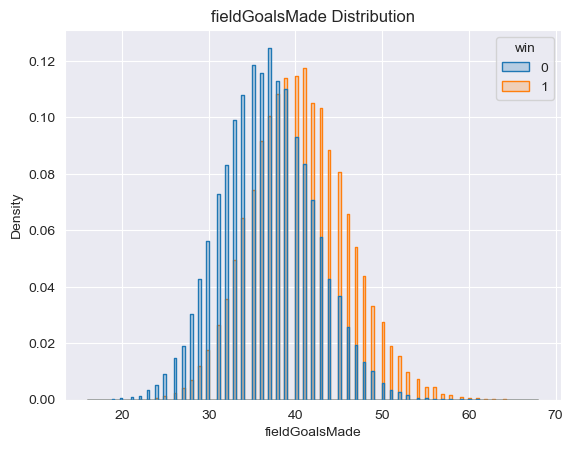

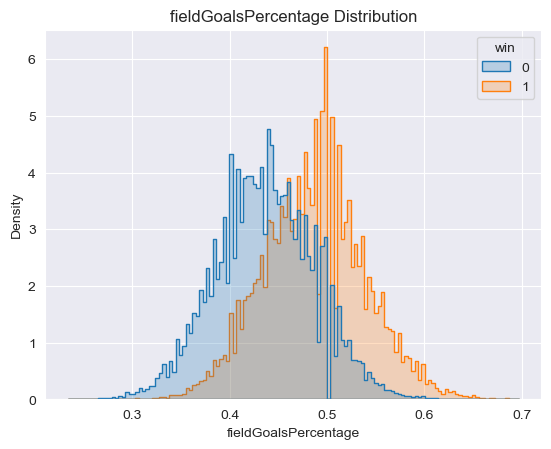

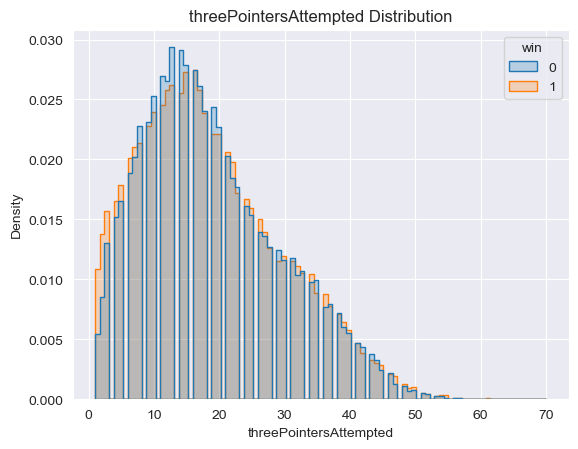

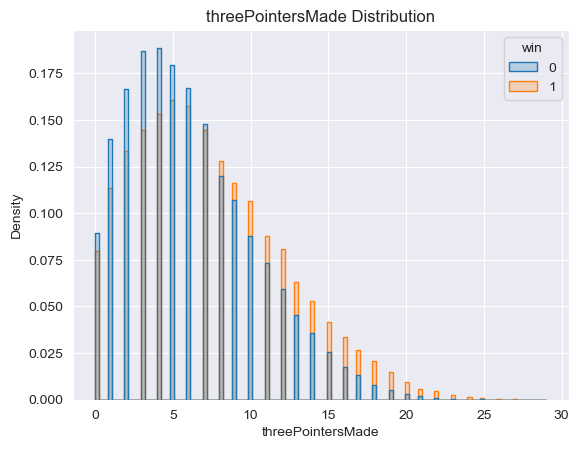

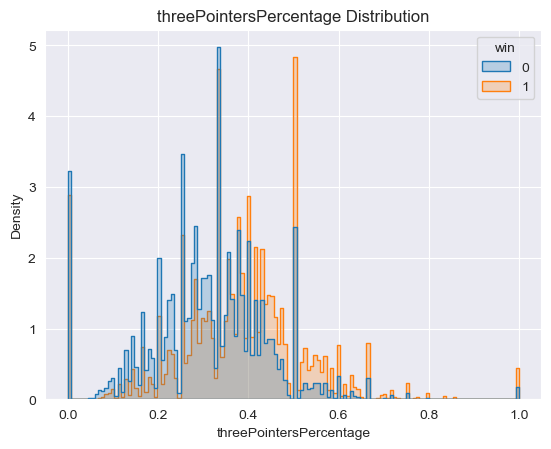

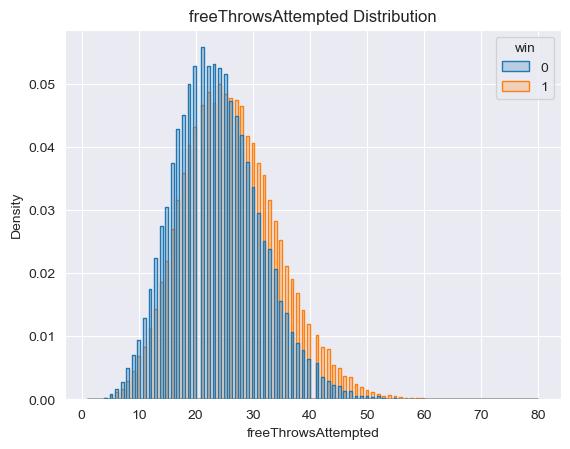

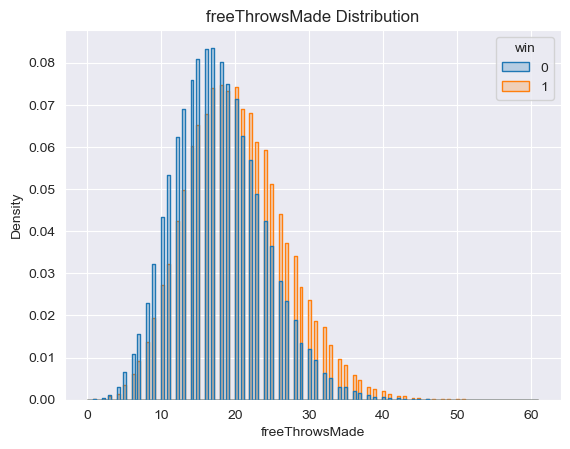

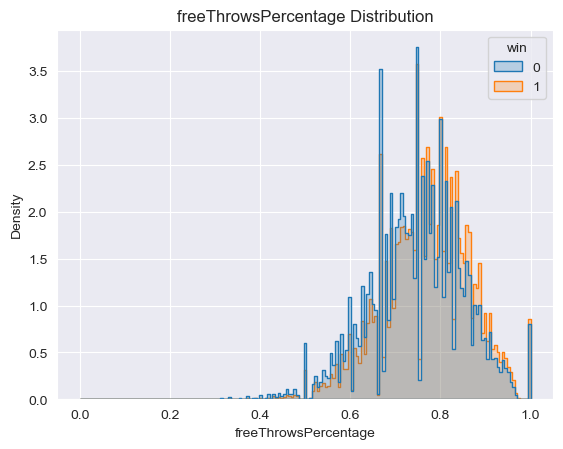

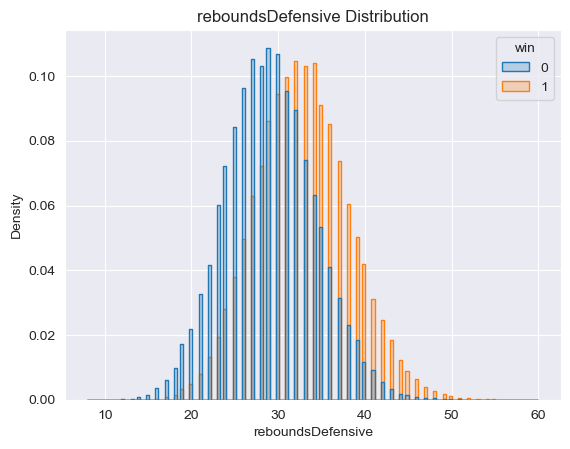

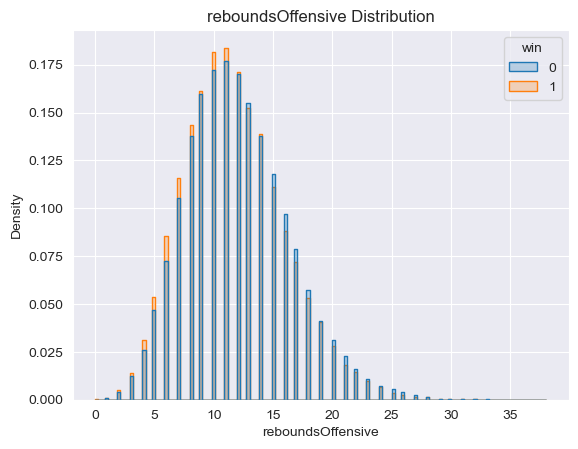

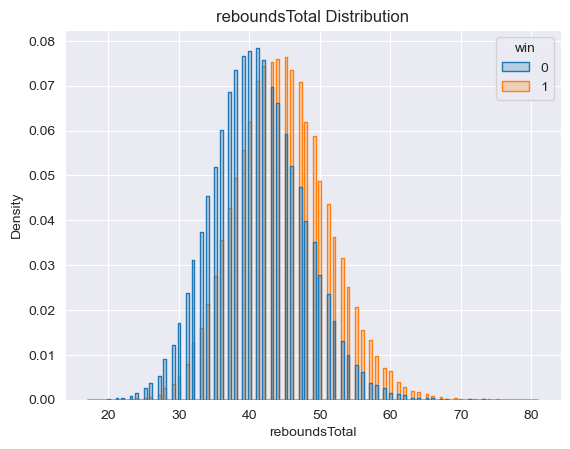

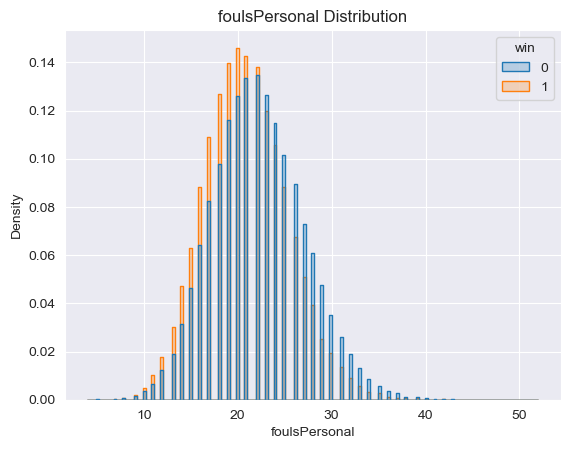

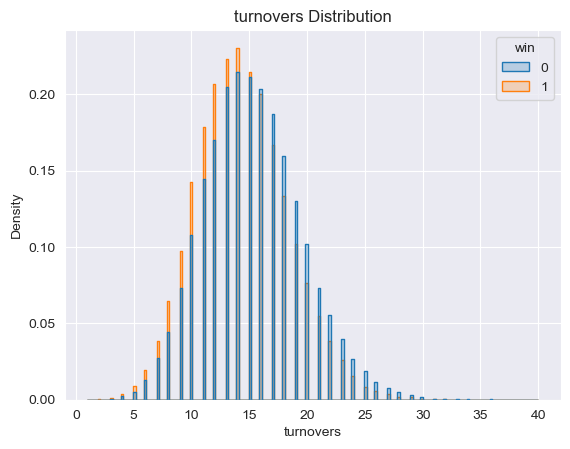

In [5]:
cols = ["home", "teamScore", "assists", "blocks", "steals", "fieldGoalsAttempted", "fieldGoalsMade", "fieldGoalsPercentage", "threePointersAttempted", "threePointersMade", "threePointersPercentage", "freeThrowsAttempted", "freeThrowsMade", "freeThrowsPercentage", "reboundsDefensive", "reboundsOffensive", "reboundsTotal", "foulsPersonal", "turnovers"]

for i, col in enumerate(cols):
    sns.histplot(data=team_statistics_df, x=col, hue='win', element='step', stat='density')
    #sns.histplot(team_statistics_df[col], ax=axs[i])
    plt.title(f"{col} Distribution")
    plt.show()



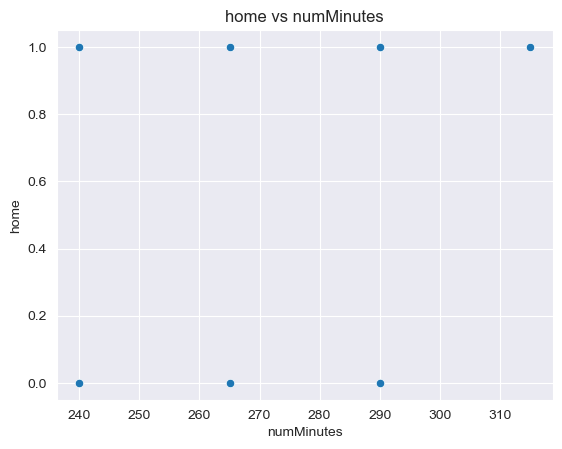

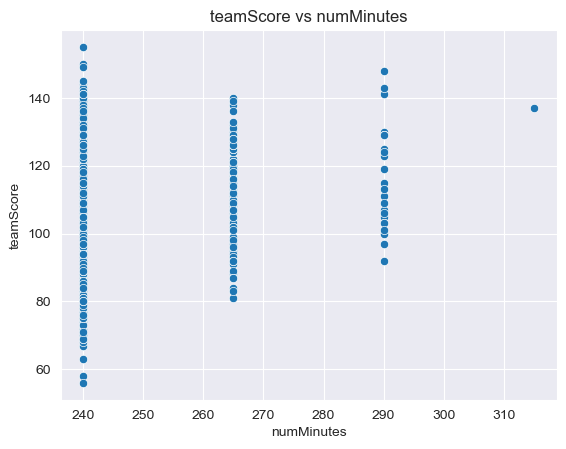

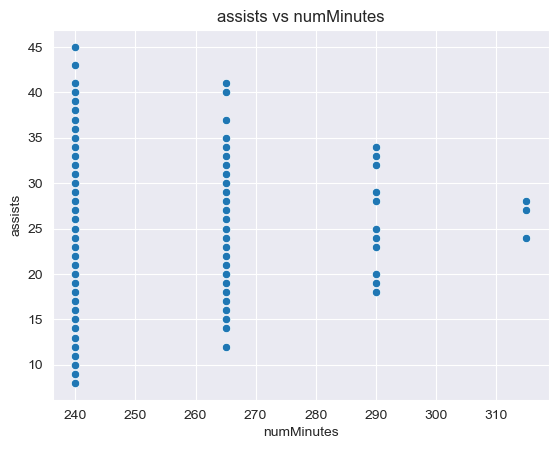

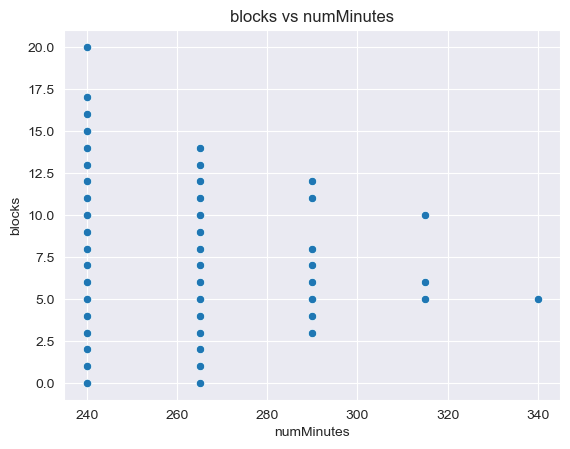

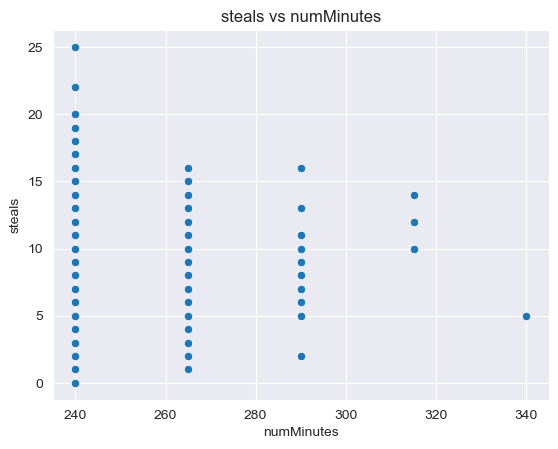

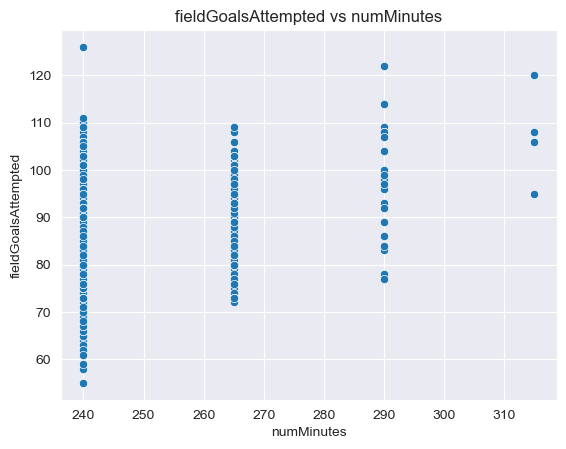

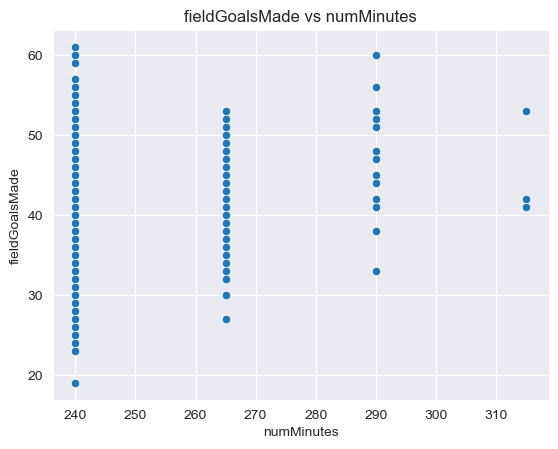

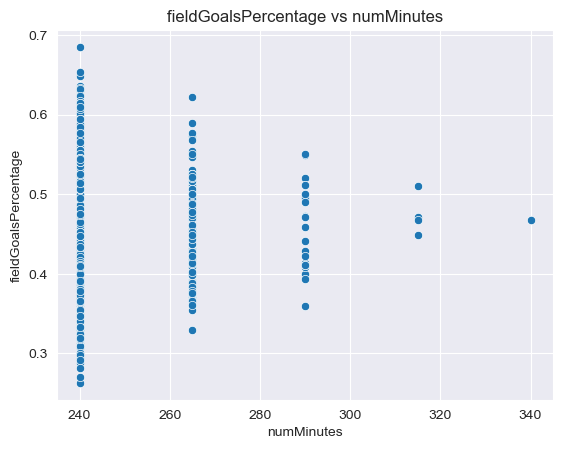

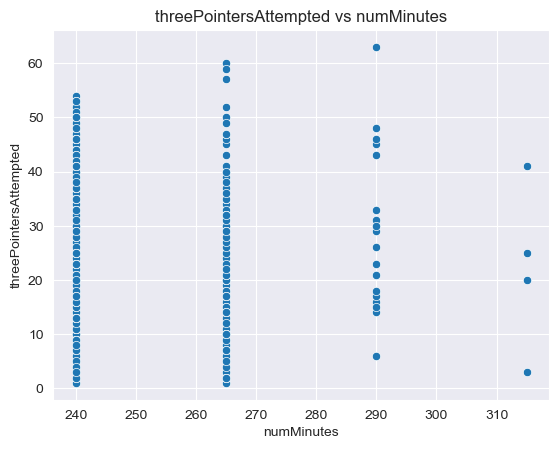

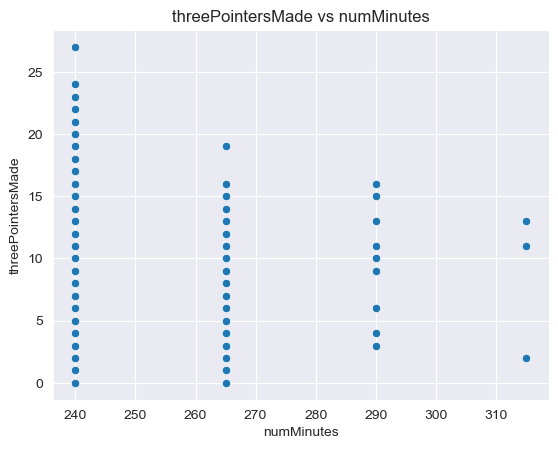

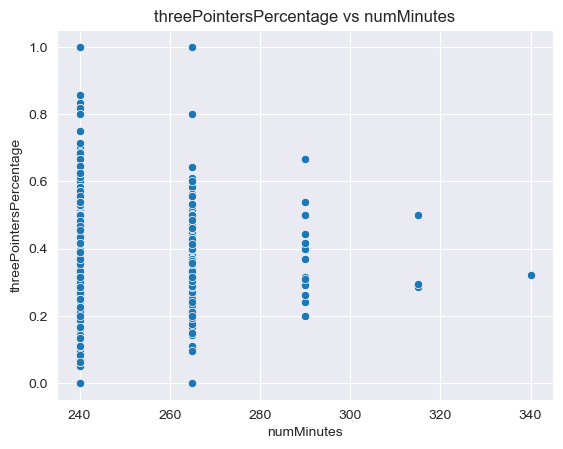

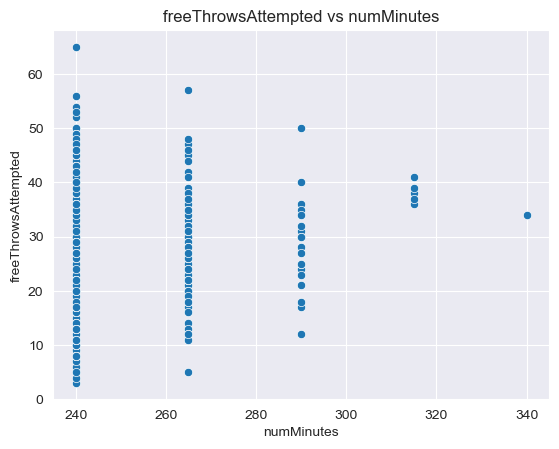

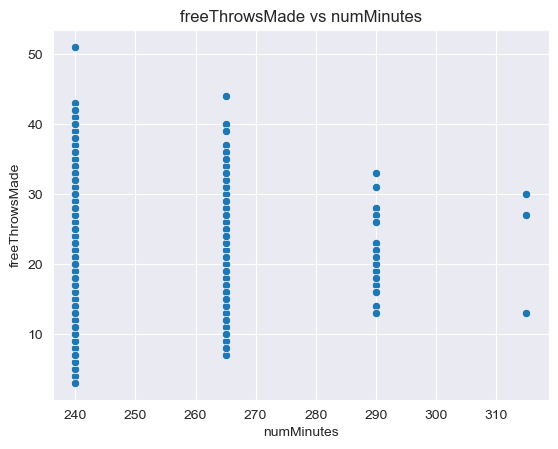

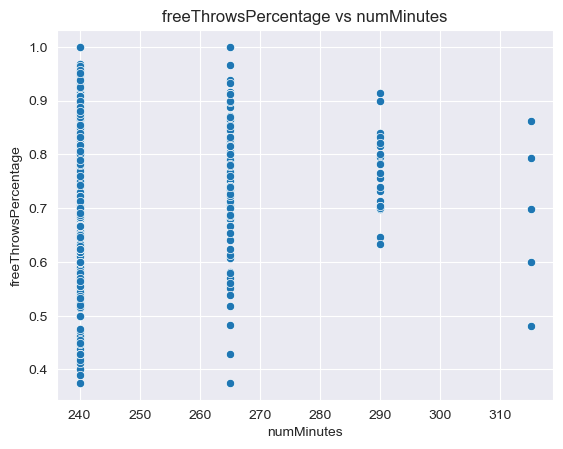

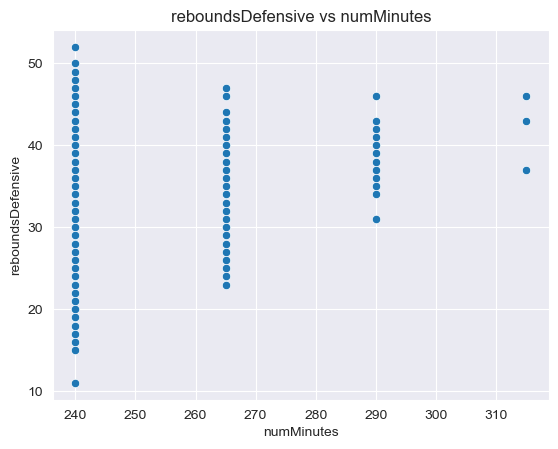

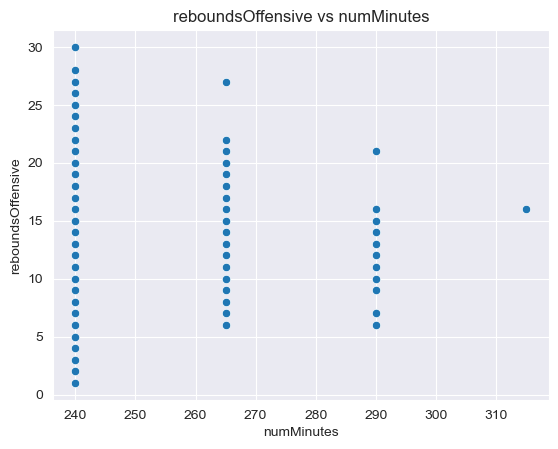

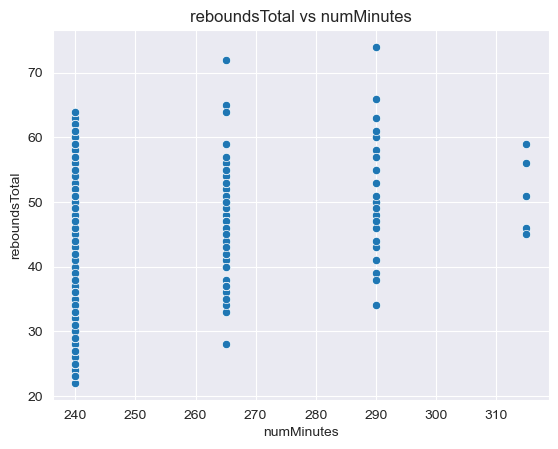

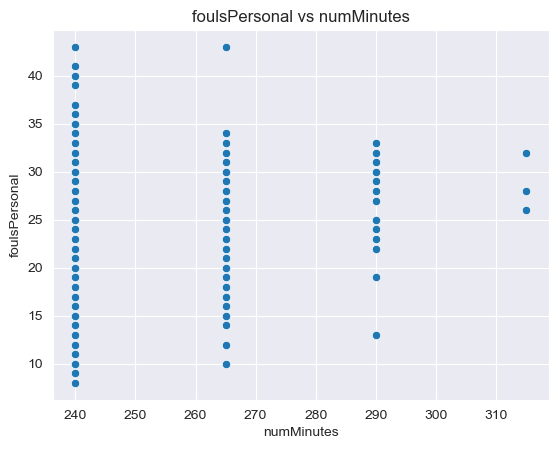

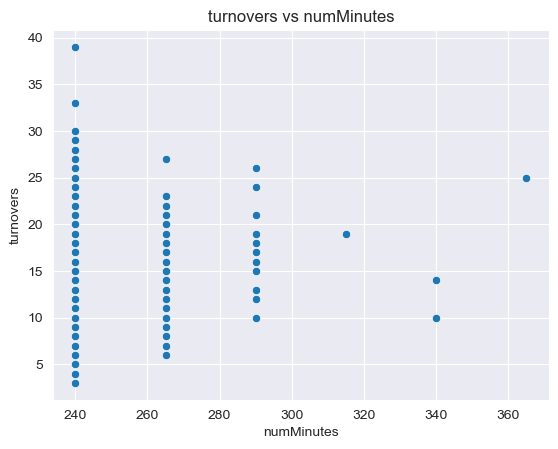

In [6]:
for col in cols:
    sns.scatterplot(x='numMinutes', y=col, data=team_statistics_df.sample(3000))
    plt.title(f'{col} vs numMinutes')
    plt.show()

Since we are dealing with countable variables, such as assists, rebounds, steals etc., if we want to show whether a winning team has more "skill" in this variable than the other, we have to account for the fact that if a team simply has more chances to score, it will have more assists, rebounds, steals etc. even though they are not better at these skills than the other team. This can be seen by the plots above showing that, by playing more minutes in a game (Overtime games for example), the trend seems to go higher for these countable variables, and the same will therefore be true if we can pack more attempts within the same minutes. So, we have to adjust the variables by the amount of possessions a team is playing at.

Conventionally, a possession is defined as a play that ends either in a turnover, a field goal, or a free throw (foul). Additionally, possessions are extended when the team gets an offensive rebound. The formula for possessions is therefore:
$$Possessions = FGA + (0.44 * FTA) + TO - OREB$$
Source: https://support.fastmodelsports.com/support/solutions/articles/9000231009-how-do-we-estimate-pace-and-possessions-

In [7]:
team_statistics_df["possessions"] = team_statistics_df["fieldGoalsAttempted"] + (0.44 * team_statistics_df["freeThrowsAttempted"]) + team_statistics_df["turnovers"] - team_statistics_df["reboundsOffensive"]

With the possessions, we can then normalize the countable variables by the amount of possessions a team is playing at.

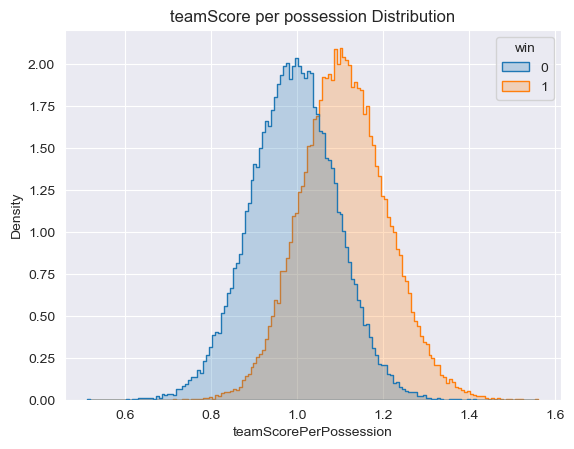

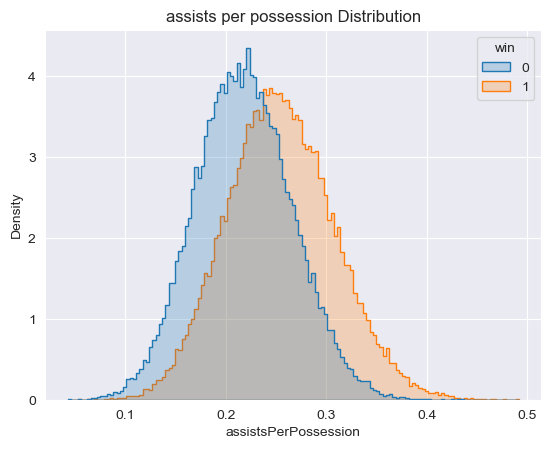

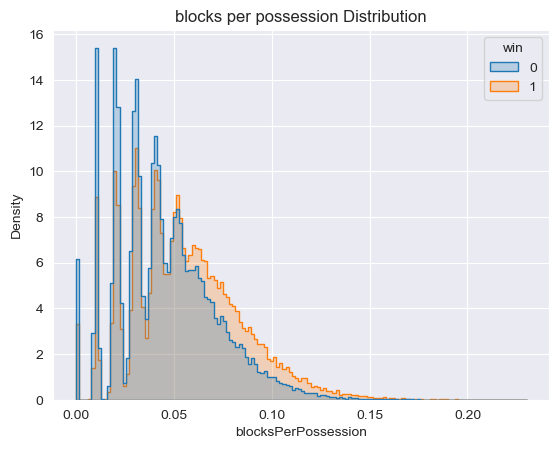

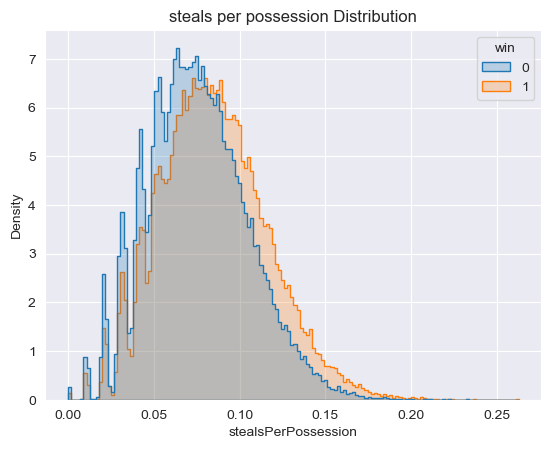

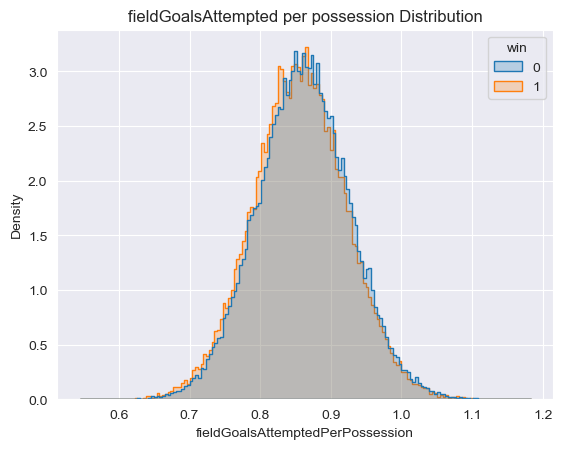

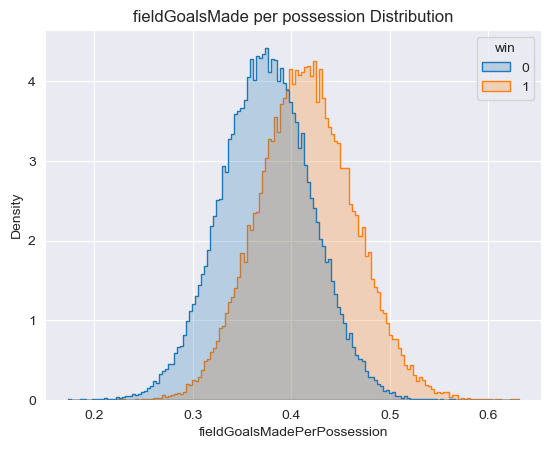

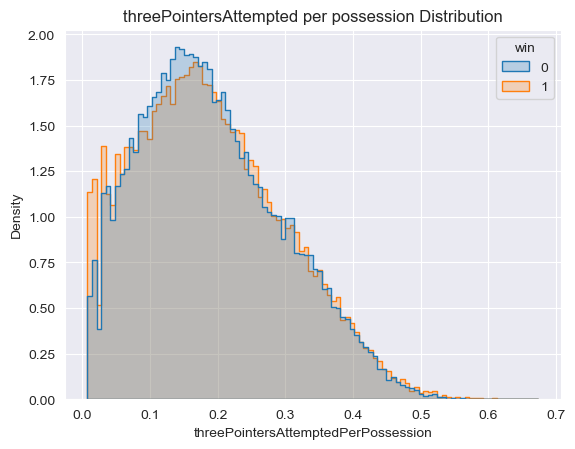

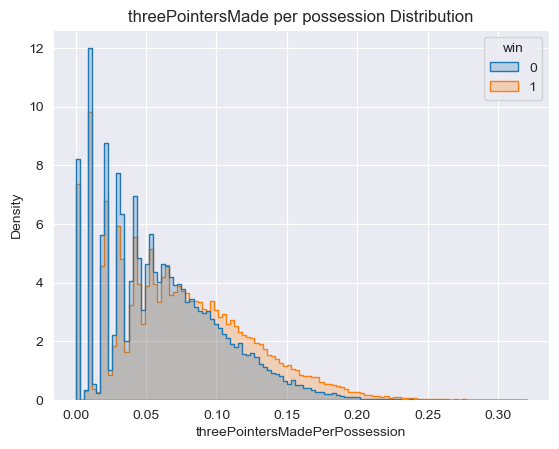

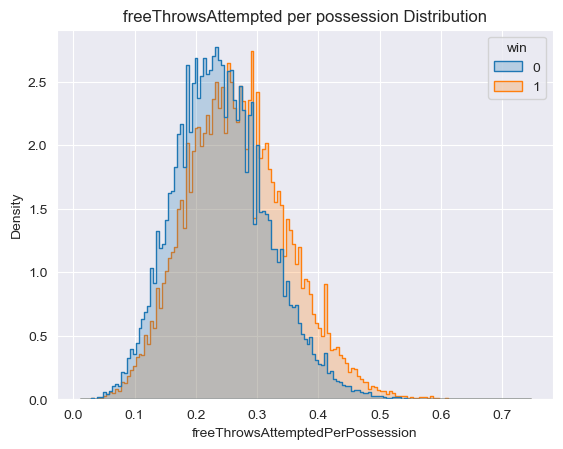

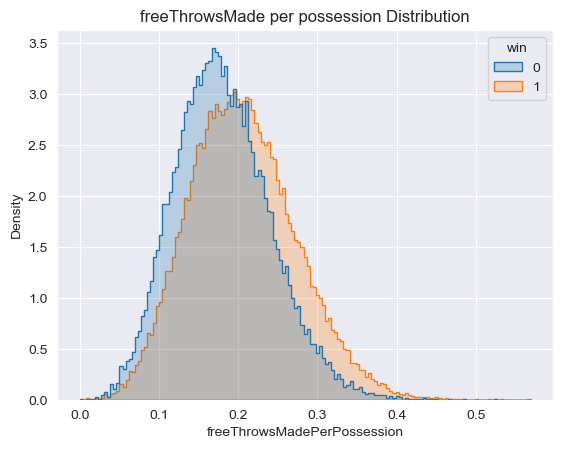

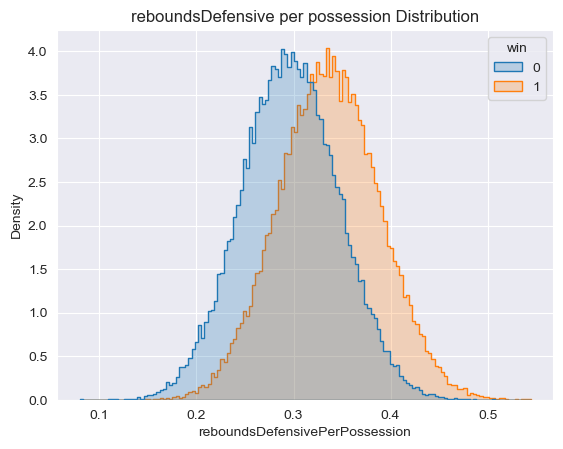

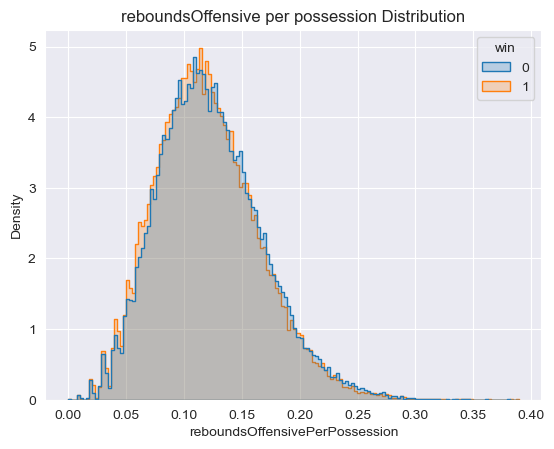

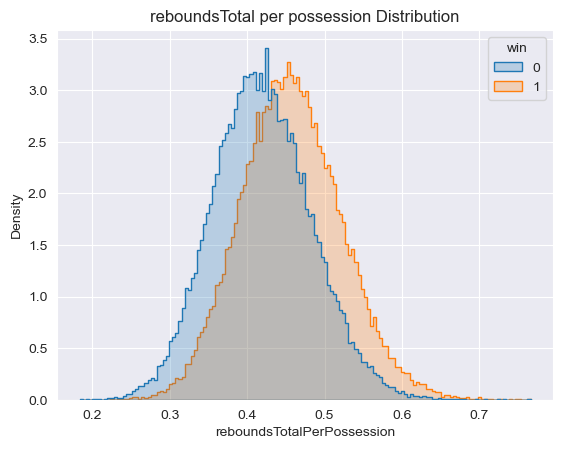

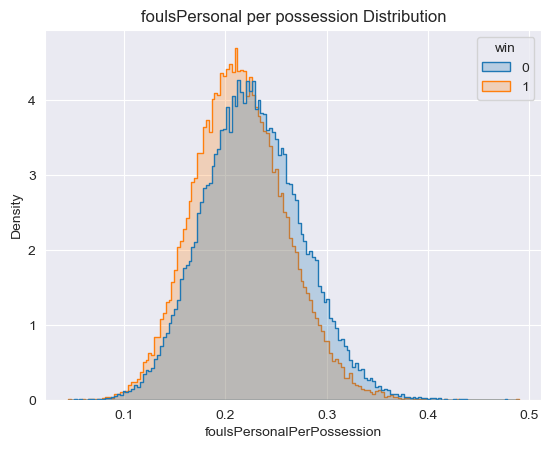

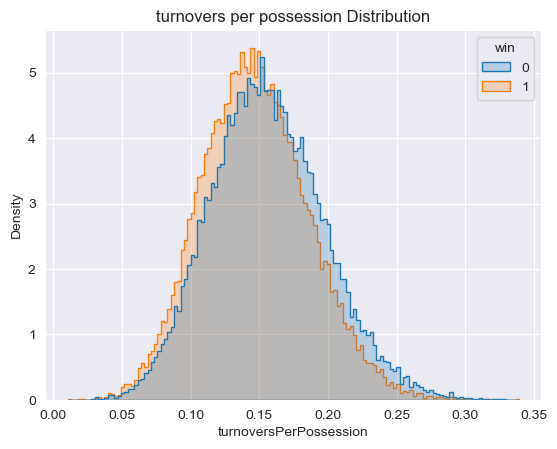

In [8]:
per_possession_cols = ["teamScore", "assists", "blocks", "steals",
                 "fieldGoalsAttempted", "fieldGoalsMade",
                 "threePointersAttempted", "threePointersMade",
                 "freeThrowsAttempted", "freeThrowsMade",
                 "reboundsDefensive", "reboundsOffensive",
                 "reboundsTotal", "foulsPersonal", "turnovers"]

for col in per_possession_cols:
    team_statistics_df[col + "PerPossession"] = team_statistics_df[col] / team_statistics_df["possessions"]
    sns.histplot(data=team_statistics_df, x=col + "PerPossession", hue='win', element='step', stat='density')
    plt.title(f"{col} per possession Distribution")
    plt.show()

We also calcualted the following metrics:

$$
\text{eFG\%} = \frac{\text{FGM} + 0.5 \times \text{3PM}}{\text{FGA}}
$$
Effective FG%: To give more weight to 3-pointers, as they give more points than 2 pointers obviously

$$
TS\% = \frac{PTS}{2 \times \left(FGA + 0.44 \cdot FTA\right)}
$$
True Shooting %: A metric that combines 2-pointers, 3-pointers and free-throws

$$
\text{Points per Shot Attempt} = \frac{PTS}{FGA}
$$
Points Per Shot Attempt (PPS): Simple shot efficiency metric

$$
FTR = \frac{FTA}{FGA}
$$
Free Throw Rate: How often you get fouled relative to shooting.

$$
\text{Assist Rate} = \frac{AST}{\text{Possessions}}
$$
Self explanatory

$$
\text{Turnover Rate} = \frac{TOV}{\text{Possessions}}
$$
Self explanatory

$$
\text{Assist to Turnover Ratio} = \frac{AST}{TOV}
$$
Self explanatory


In [9]:
# Calculate all metrics above:
team_statistics_df['effectiveFieldGoalPercentage'] = team_statistics_df['fieldGoalsMade'] + 0.5 * team_statistics_df['threePointersAttempted'] / team_statistics_df['fieldGoalsAttempted']
team_statistics_df['trueShootingPercentage'] = team_statistics_df['teamScore'] / (2 * (team_statistics_df['fieldGoalsAttempted'] + 0.44 * team_statistics_df['freeThrowsAttempted']))
team_statistics_df['pointsPerShotAttempt'] = team_statistics_df['teamScore'] / team_statistics_df['fieldGoalsAttempted']
team_statistics_df['freeThrowRate'] = team_statistics_df['freeThrowsAttempted'] / team_statistics_df['fieldGoalsMade']
team_statistics_df['assistRate'] = team_statistics_df['assists'] / team_statistics_df['possessions']
team_statistics_df['turnoverRate'] = team_statistics_df['turnovers'] / team_statistics_df['possessions']
team_statistics_df['assistToTurnover'] = team_statistics_df['assists'] / team_statistics_df['turnovers']

In [10]:
# Save the dataframe to a csv file
team_statistics_df.to_csv(os.path.join(DATA_PATH, "team_statistics_advanced.csv"), index=False)

We can now move on to testing:

In [11]:
win = team_statistics_df[team_statistics_df["win"] == 1]
loss = team_statistics_df[team_statistics_df["win"] == 0]
paired = pd.merge(win, loss, on=["gameId"], suffixes=("_win", "_loss"))

In [21]:
cols = [c for c in team_statistics_df.columns if c.endswith("PerPossession") or c.endswith("Percentage")]
cols_additional = ["pointsPerShotAttempt", "freeThrowRate", "assistRate", "turnoverRate", "assistToTurnover"]
cols = cols + cols_additional


differences = paired[[f"{col}_win" for col in cols]].values - paired[[f"{col}_loss" for col in cols]].values
differences = pd.DataFrame(differences, columns=cols)

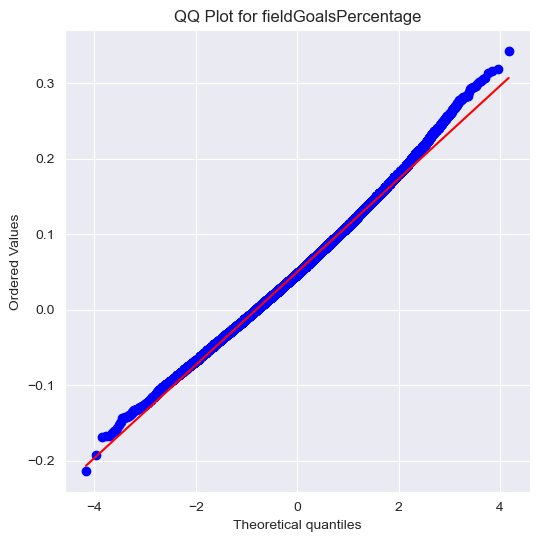

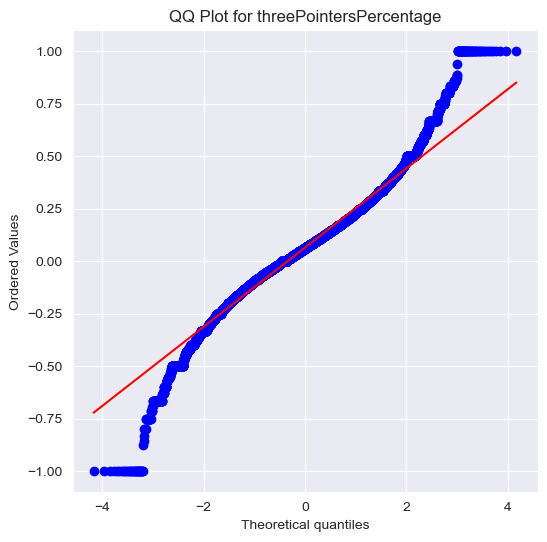

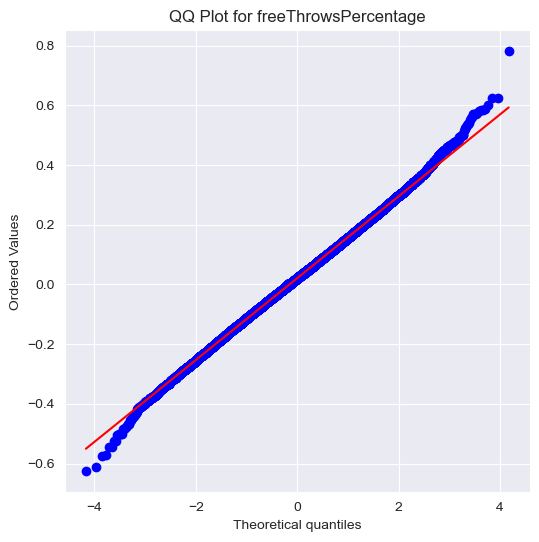

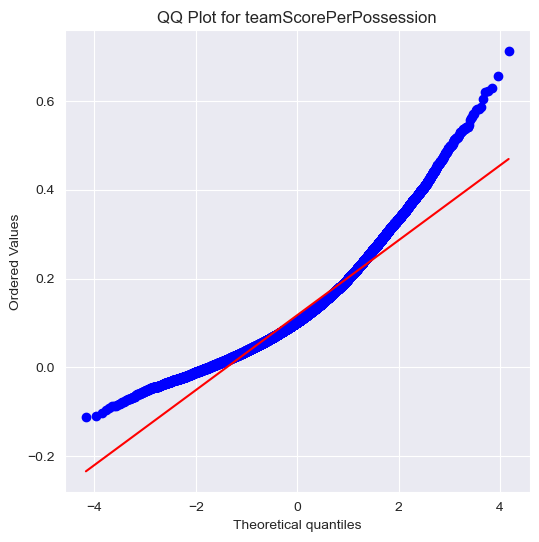

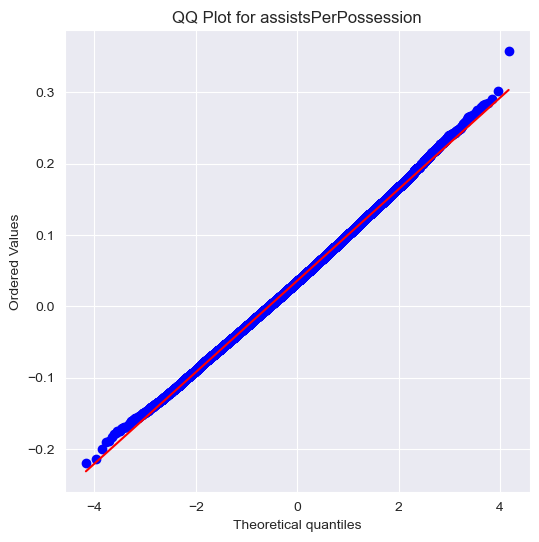

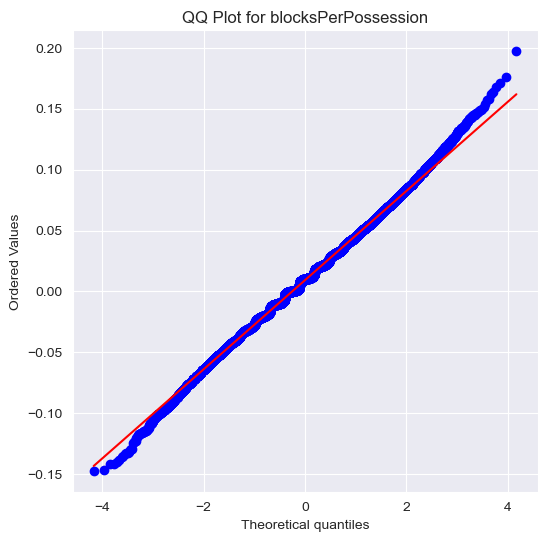

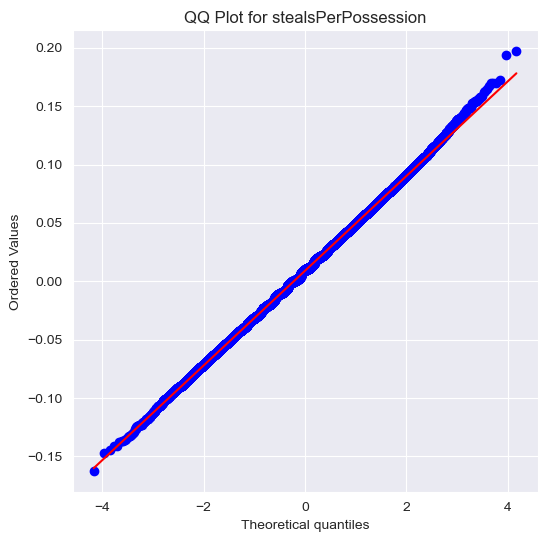

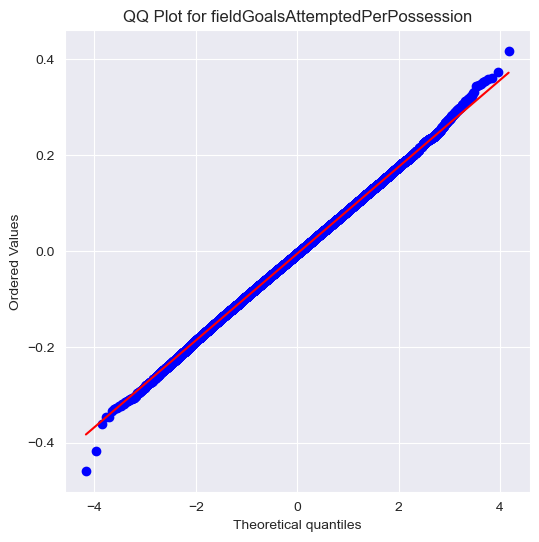

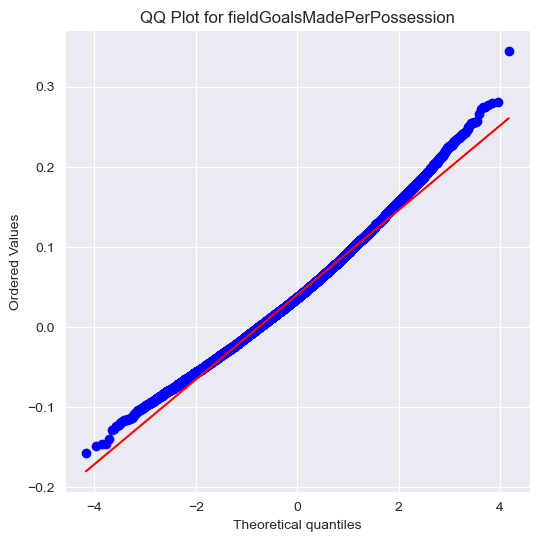

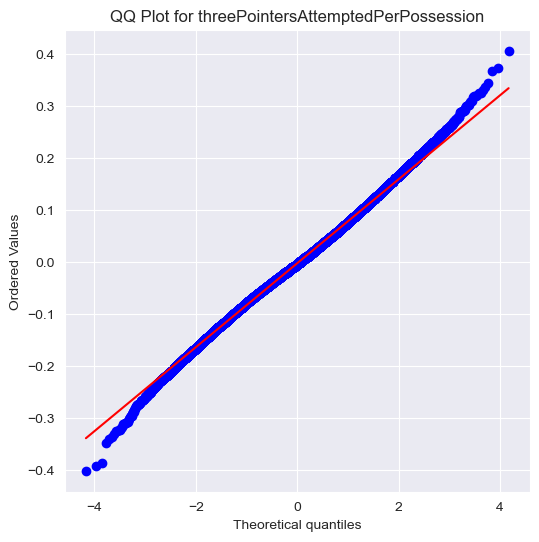

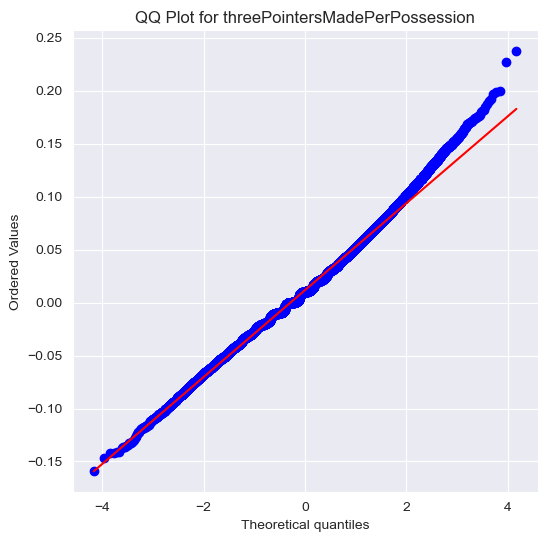

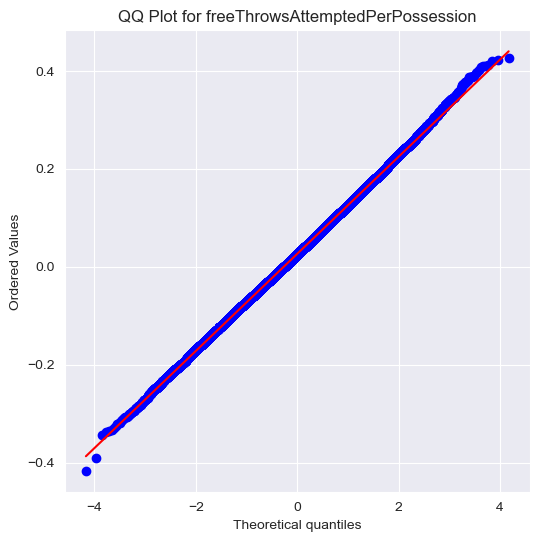

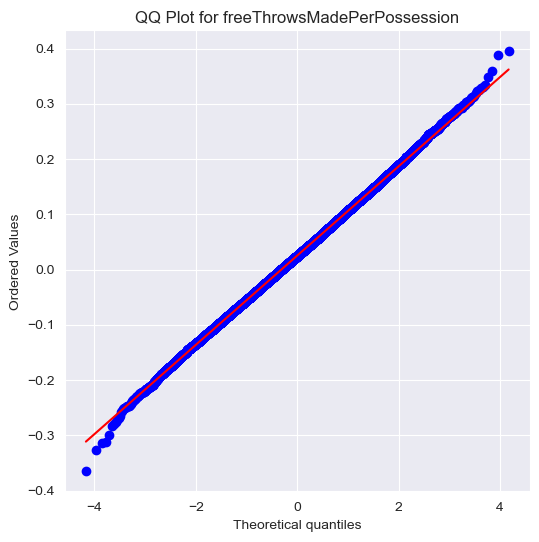

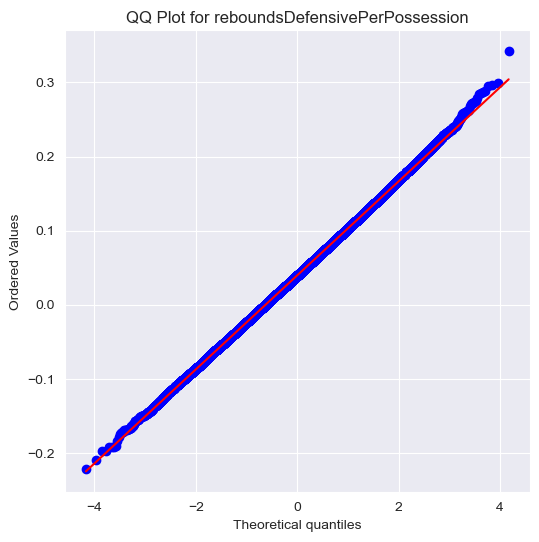

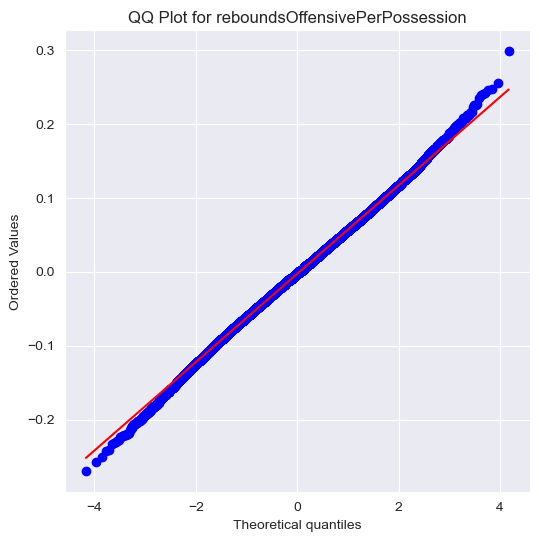

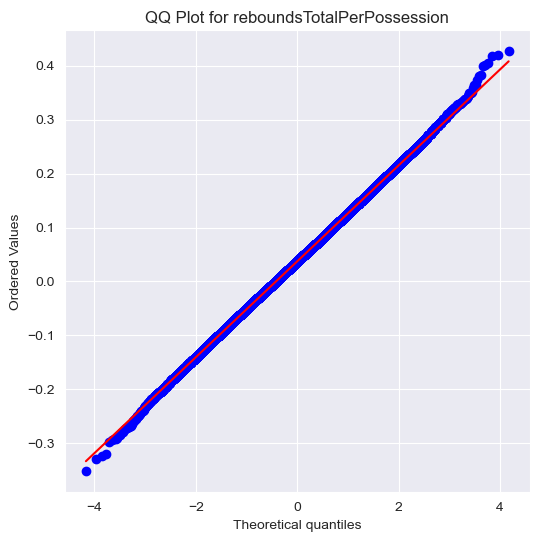

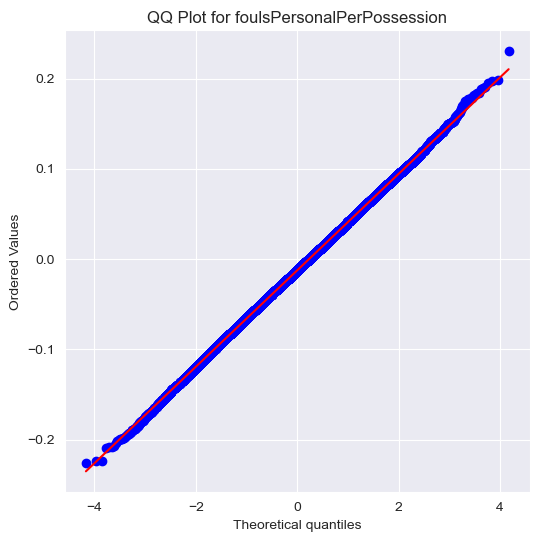

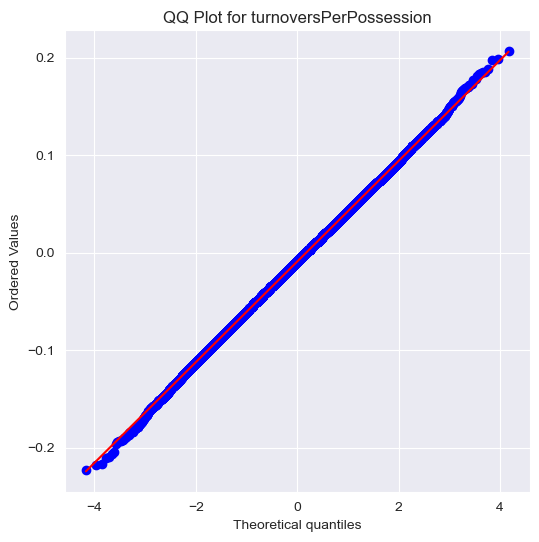

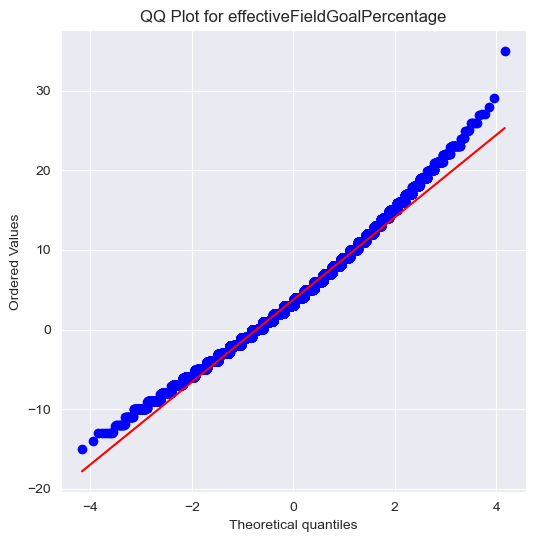

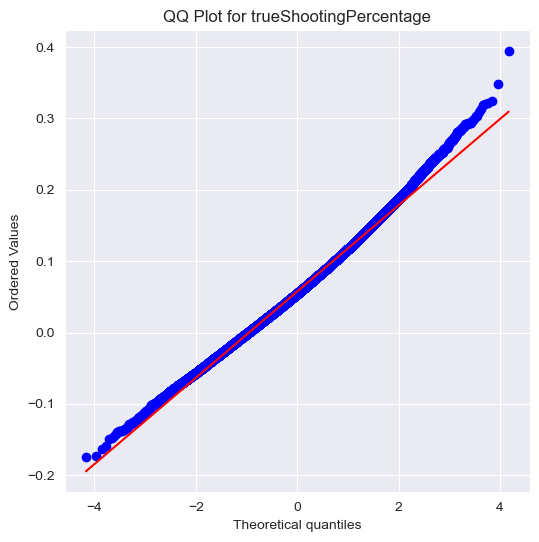

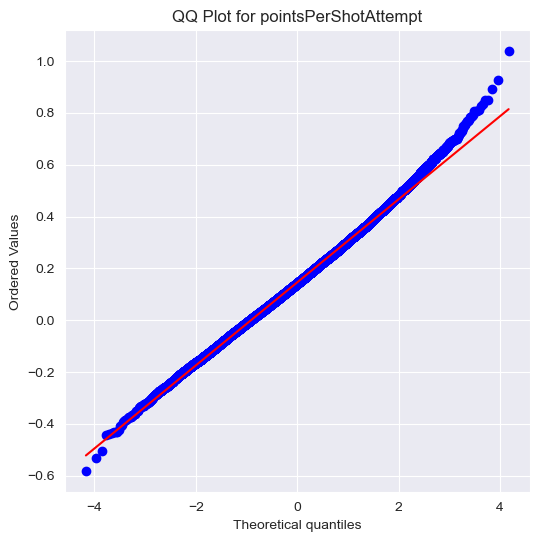

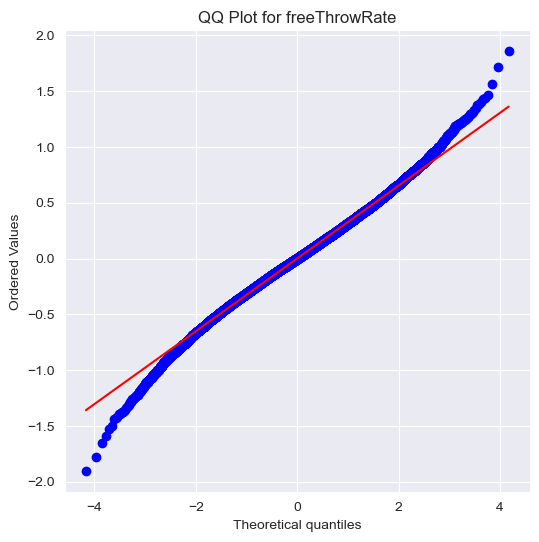

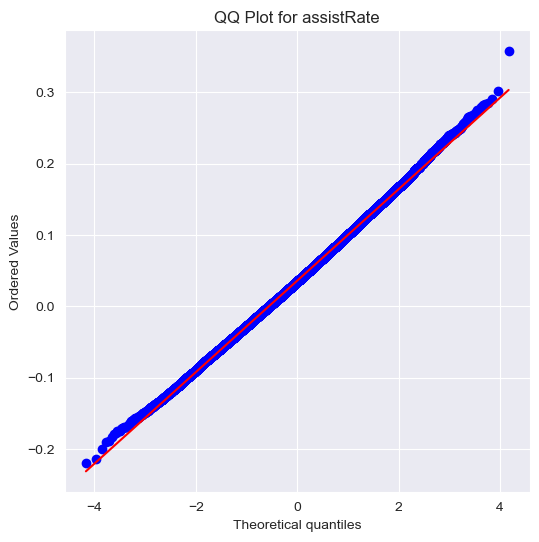

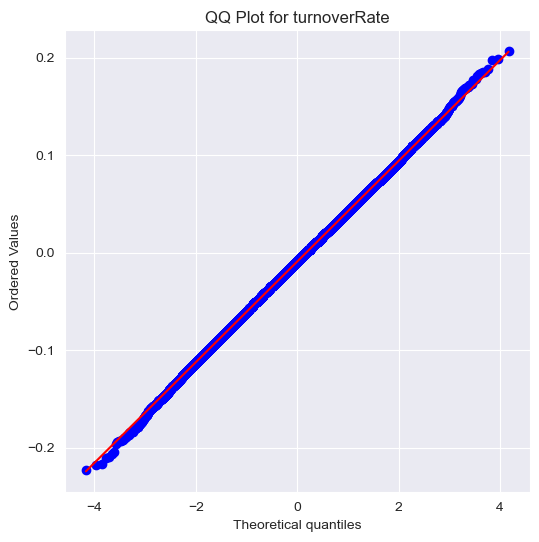

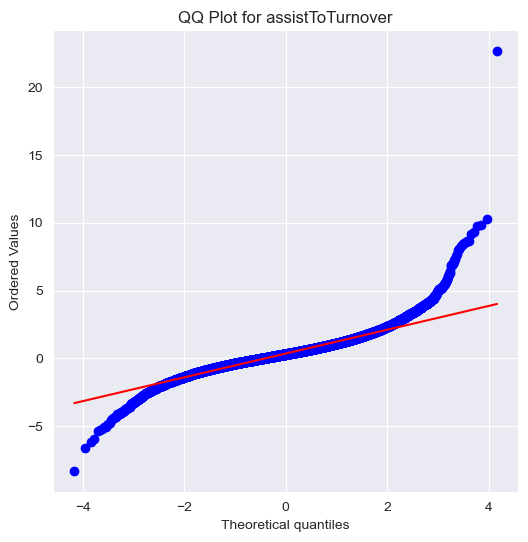

In [15]:
# Plot QQ Plots
for col in differences.columns:
    plt.figure(figsize=(6, 6))
    stats.probplot(differences[col], dist="norm", plot=plt)
    plt.title(f"QQ Plot for {col}")
    plt.show()

All distributions do follow a Normal Distributions when inspecting the QQ-Plots apart from teamScorePerPossessions and assistToTurnover. The only outlier is the threePointersPercentage, whose QQ-Plot suggests that the distribution has heavy tails. This can be attributed to the fact that three pointers weren't commonly thrown in earlier years (such as the 80s, 90s etc.) and therefore there were a lot of games where no threes were taken or 0/1 or 1/1 threes were made, leading to the heavy tails.

In [16]:
# Print rows where threePointersPercentage == 1.0
team_statistics_df[team_statistics_df["threePointersPercentage"] == 1.0]

,gameId,gameDate,teamCity,teamName,teamId,opponentTeamCity,opponentTeamName,opponentTeamId,home,win,...,reboundsTotalPerPossession,foulsPersonalPerPossession,turnoversPerPossession,effectiveFieldGoalPercentage,trueShootingPercentage,pointsPerShotAttempt,freeThrowRate,assistRate,turnoverRate,assistToTurnover
43693,20600593,2007-01-20 19:00:00,Atlanta,Hawks,1610612737,Charlotte,Bobcats,1610612766,0,0,...,0.332349,0.283112,0.209257,33.007692,0.572468,1.307692,0.636364,0.184638,0.209257,0.882353
44125,20600375,2006-12-20 22:30:00,Los Angeles,Clippers,1610612746,Toronto,Raptors,1610612761,1,0,...,0.491291,0.234480,0.100491,38.005952,0.507614,1.142857,0.631579,0.290308,0.100491,2.888889
47551,20401112,2005-04-06 20:00:00,Denver,Nuggets,1610612743,New Orleans,Hornets,1610612740,0,1,...,0.433221,0.221893,0.126796,33.019737,0.524320,1.236842,0.939394,0.243026,0.126796,1.916667
48106,20400833,2005-02-28 21:00:00,Los Angeles,Clippers,1610612746,Utah,Jazz,1610612762,0,0,...,0.405341,0.298045,0.190749,30.014286,0.525159,1.228571,0.900000,0.190749,0.190749,1.000000
52284,20201105,2003-04-06 15:30:00,Philadelphia,76ers,1610612755,Sacramento,Kings,1610612758,1,0,...,0.487465,0.179069,0.159172,29.005747,0.398936,0.931034,1.137931,0.159172,0.159172,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90430,28500021,1985-10-27 20:00:00,Portland,Trail Blazers,1610612757,Golden State,Warriors,1610612744,1,1,...,0.372321,0.263349,0.236106,47.011236,0.585149,1.303371,0.489362,0.308754,0.236106,1.307692
90464,28300590,1984-02-15 20:00:00,Dallas,Mavericks,1610612742,Philadelphia,76ers,1610612755,1,1,...,0.300791,0.197662,0.223444,52.005556,0.604921,1.322222,0.365385,0.283603,0.223444,1.269231
90475,28300017,1983-10-29 20:00:00,Philadelphia,76ers,1610612755,Indiana,Pacers,1610612754,0,1,...,0.434860,0.283990,0.239617,44.006024,0.597994,1.493976,1.068182,0.239617,0.239617,1.000000
90486,28100566,1982-02-14 20:00:00,Milwaukee,Bucks,1610612749,Cleveland,Cavaliers,1610612739,0,1,...,0.384460,0.263051,0.151760,49.006579,0.680531,1.644737,0.734694,0.333873,0.151760,2.200000


In [17]:
# Perform ttest of differences
from statsmodels.stats.multitest import multipletests
import pingouin as pg

results = []
for col in cols:
    diffs = differences[col]

    if col == "teamScorePerPossession" or col == "assistToTurnover":
        res = pg.wilcoxon(diffs)
        statistic = res['W-val'].iloc[0]
        p_value = res['p-val'].iloc[0]
        effect_size = res['RBC'].iloc[0]
    else:
        statistic, p_value = stats.ttest_1samp(diffs, 0)
        effect_size = diffs.mean() / diffs.std(ddof=1)
    results.append({
        'col': col,
        'mean_diff': diffs.mean(),
        'std_diff': diffs.std(ddof=1),
        't_statistic': statistic,
        'p_value': p_value,
        'effect_size': effect_size
    })

results_df = pd.DataFrame(results)

# Bonferri Correction
results_df['corrected_p_value'] = multipletests(results_df['p_value'], method='bonferroni')[1]
results_df = results_df.sort_values('effect_size', ascending=False).reset_index(drop=True)
results_df

,col,mean_diff,std_diff,t_statistic,p_value,effect_size,corrected_p_value
0,teamScorePerPossession,0.117938,0.086893,5.746890e+06,0.000000e+00,0.988535,0.000000e+00
1,trueShootingPercentage,0.057481,0.060590,2.007481e+02,0.000000e+00,0.948689,0.000000e+00
2,pointsPerShotAttempt,0.146268,0.160501,1.928401e+02,0.000000e+00,0.911318,0.000000e+00
3,fieldGoalsPercentage,0.050014,0.061695,1.715419e+02,0.000000e+00,0.810668,0.000000e+00
4,fieldGoalsMadePerPossession,0.040324,0.053101,1.606879e+02,0.000000e+00,0.759374,0.000000e+00
5,effectiveFieldGoalPercentage,3.748978,5.198395,1.526058e+02,0.000000e+00,0.721180,0.000000e+00
6,reboundsDefensivePerPossession,0.039940,0.063379,1.333482e+02,0.000000e+00,0.630173,0.000000e+00
7,assistRate,0.036166,0.064055,1.194733e+02,0.000000e+00,0.564603,0.000000e+00
8,assistsPerPossession,0.036166,0.064055,1.194733e+02,0.000000e+00,0.564603,0.000000e+00
9,assistToTurnover,0.359089,0.906952,2.617085e+08,0.000000e+00,0.469612,0.000000e+00


We have also performed bonferri correction to adjust for the fact we have been running multiple tests, but they are all highly significant results. We have also used Cohen's d metric to identify the effect size, where a value of 0.2 represents a small, 0.5 a medium and 0.8 a large effect. The exception is the teamScore, where because of non-normality we have performed a wilcoxon test with Biserial-Rank effect size, where 0.1 is small, 0.3 is medium and 0.5 is large.
From the table we can identify that the largest differences between winning and losing teams are the team score unsurprisingly. Another interesting note is that defensive rebounds are quite a bit more important than assists, indicating that perhaps teamplay isn't quite as important. Another interesting fact is that turnoversPerPossession does not have a high effect size (-0.16), indicating that even if a team commits a lot of turnovers isn't quite as punishing.

threePointersPercentage does not have a huge effect size, but given the heavy tails due to the already mentioned facts, I wanted to explore what happens if we limit the years to since 2000.

In [18]:
# Select games where gameDate has 2000 or later in it
team_statistics_df['gameDate'] = pd.to_datetime(team_statistics_df['gameDate'])

team_statistics_df_2000 = team_statistics_df[team_statistics_df["gameDate"].dt.year >= 2010]
team_statistics_df_2000.head()

,gameId,gameDate,teamCity,teamName,teamId,opponentTeamCity,opponentTeamName,opponentTeamId,home,win,...,reboundsTotalPerPossession,foulsPersonalPerPossession,turnoversPerPossession,effectiveFieldGoalPercentage,trueShootingPercentage,pointsPerShotAttempt,freeThrowRate,assistRate,turnoverRate,assistToTurnover
0,22401058,2025-03-26 22:00:00,Boston,Celtics,1610612738,Phoenix,Suns,1610612756,0,1,...,0.491400,0.184275,0.102375,45.292135,0.668829,1.483146,0.488889,0.337838,0.102375,3.300000
1,22401058,2025-03-26 22:00:00,Phoenix,Suns,1610612756,Boston,Celtics,1610612738,1,0,...,0.386808,0.183225,0.132329,36.235632,0.529925,1.172414,0.583333,0.223941,0.132329,1.692308
2,22401057,2025-03-26 21:00:00,Denver,Nuggets,1610612743,Milwaukee,Bucks,1610612749,1,1,...,0.456893,0.119190,0.089392,49.205556,0.637039,1.411111,0.448980,0.357569,0.089392,4.000000
3,22401057,2025-03-26 21:00:00,Milwaukee,Bucks,1610612749,Denver,Nuggets,1610612743,0,0,...,0.399099,0.143266,0.112567,46.207865,0.617610,1.314607,0.282609,0.307000,0.112567,2.727273
4,22401054,2025-03-26 19:30:00,Brooklyn,Nets,1610612751,Toronto,Raptors,1610612761,1,0,...,0.412035,0.201227,0.182062,31.235632,0.450923,0.988506,0.612903,0.153315,0.182062,0.842105


In [19]:
win_2000 = team_statistics_df_2000[team_statistics_df_2000["win"] == 1]
loss_2000 = team_statistics_df_2000[team_statistics_df_2000["win"] == 0]
paired_2000 = pd.merge(win_2000, loss_2000, on=["gameId"], suffixes=("_win", "_loss"))

In [22]:
differences_2000 = paired_2000[[f"{col}_win" for col in cols]].values - paired_2000[[f"{col}_loss" for col in cols]].values
differences_2000 = pd.DataFrame(differences_2000, columns=cols)

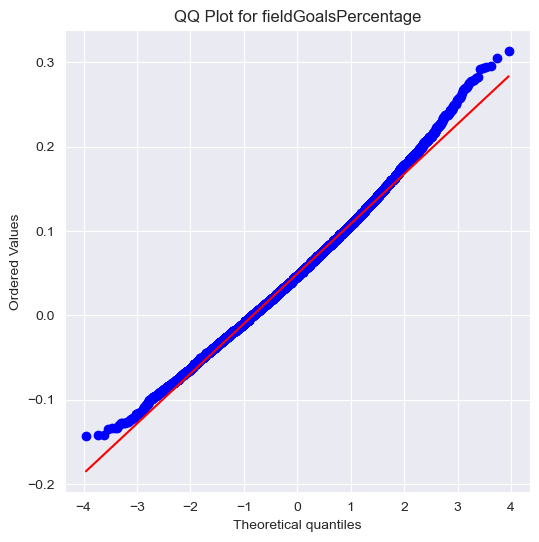

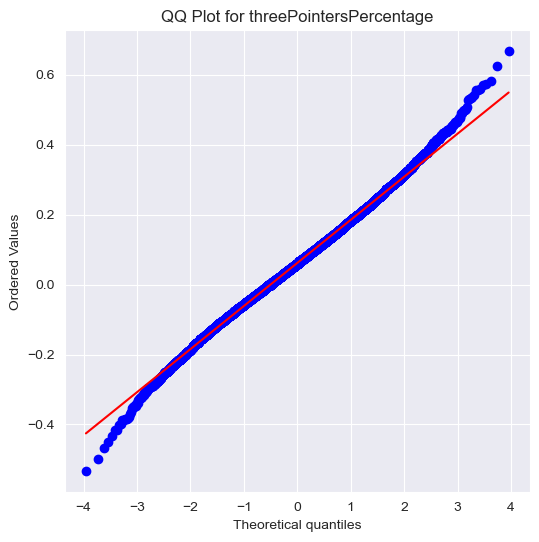

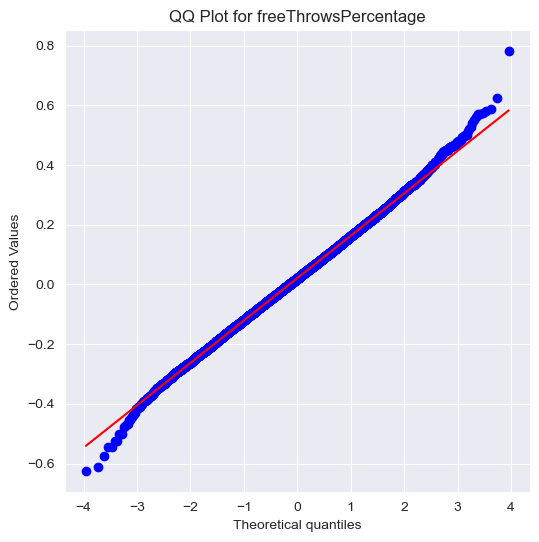

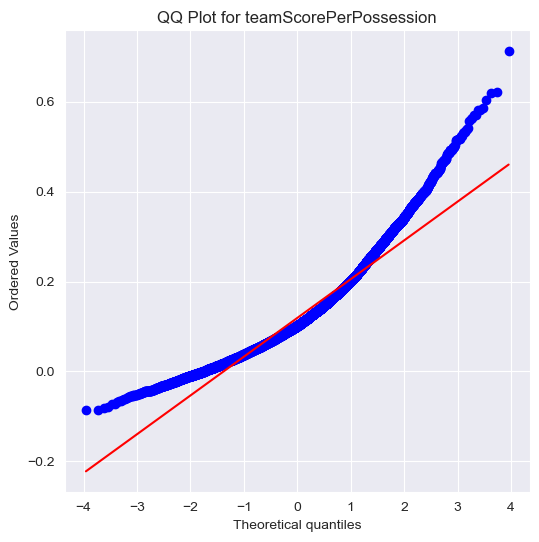

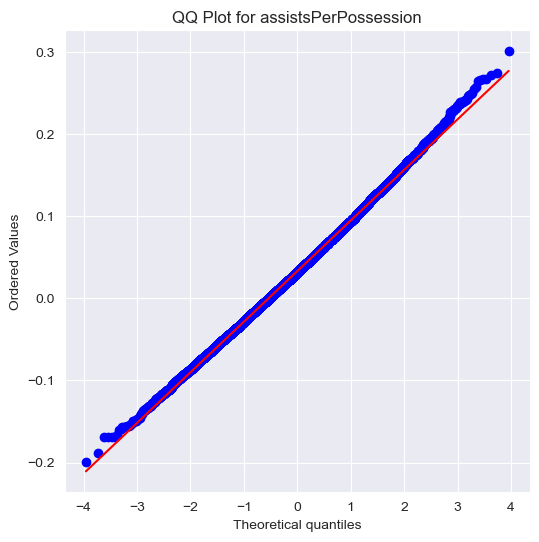

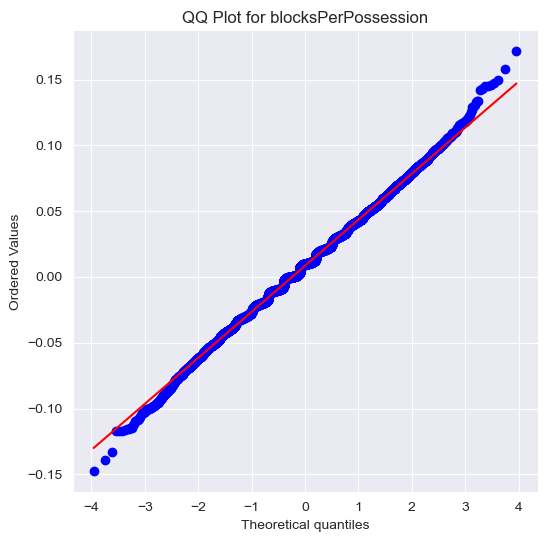

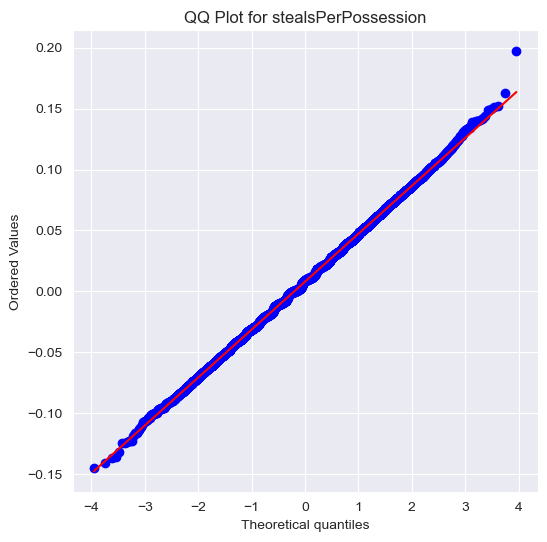

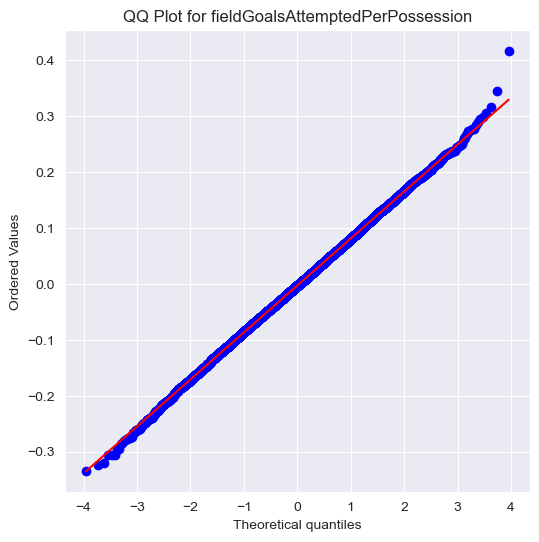

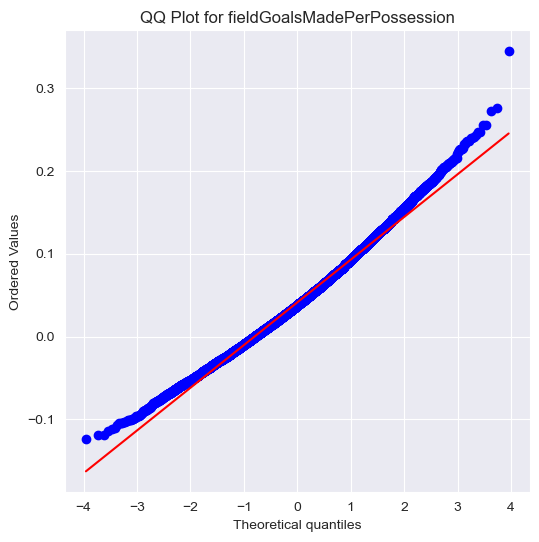

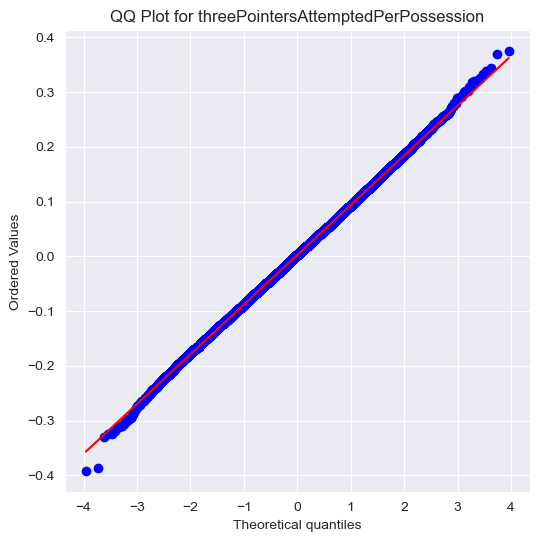

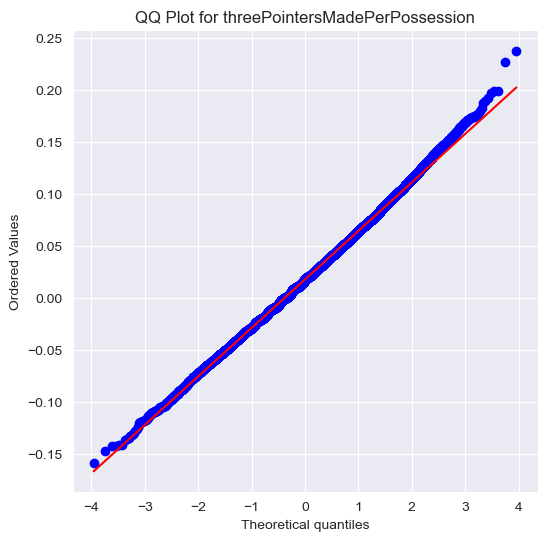

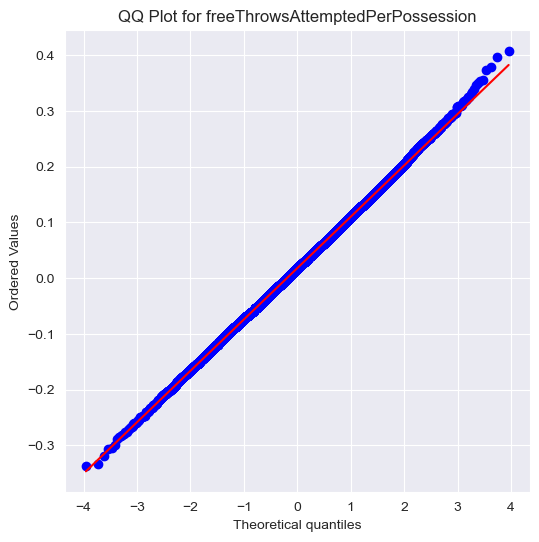

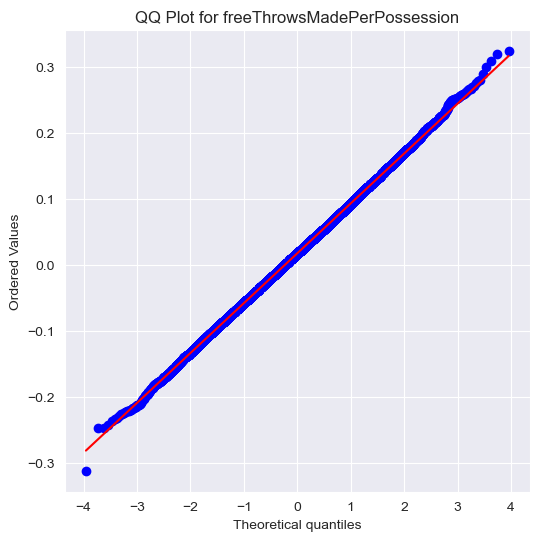

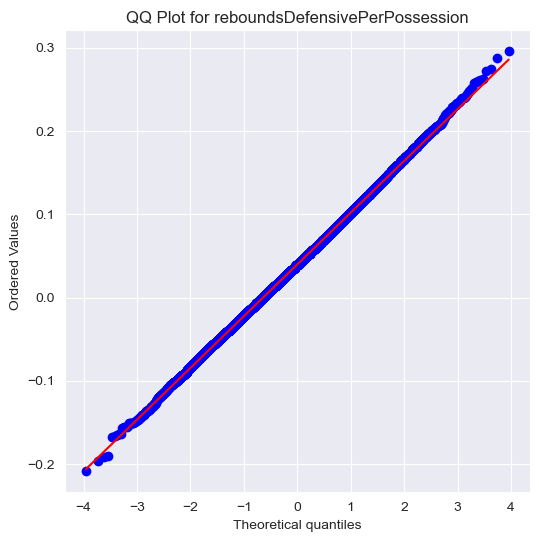

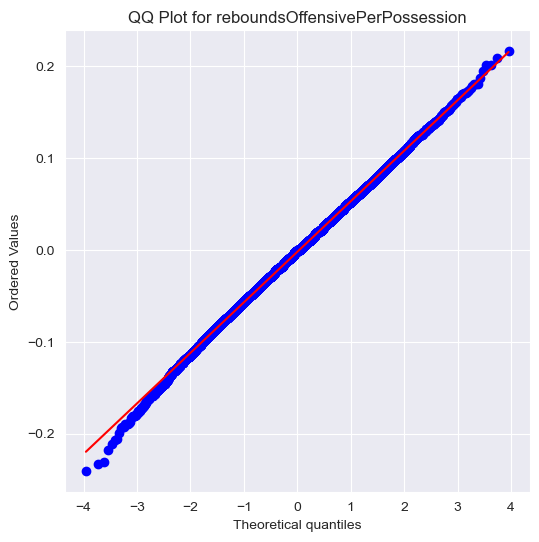

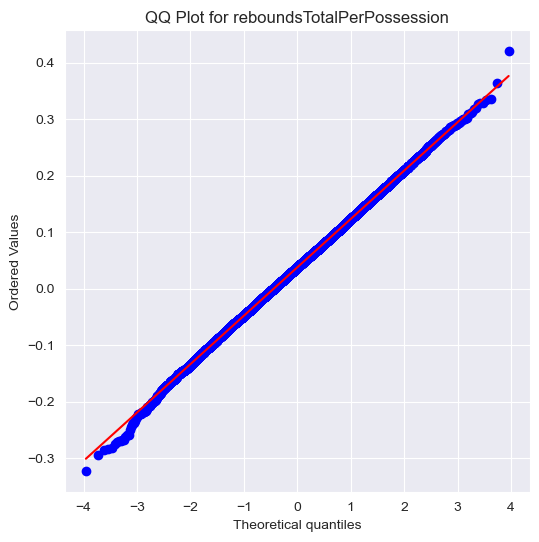

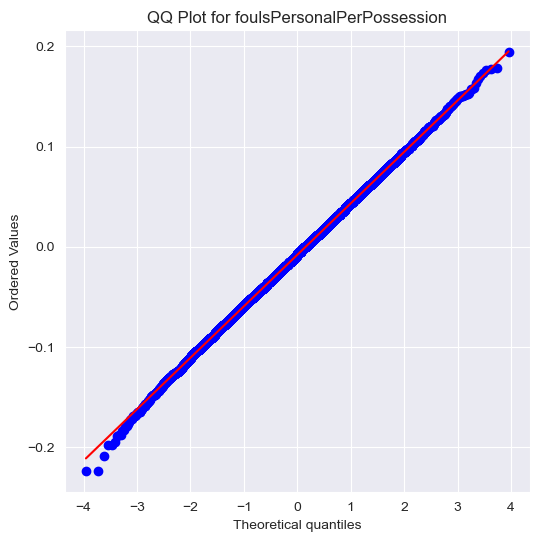

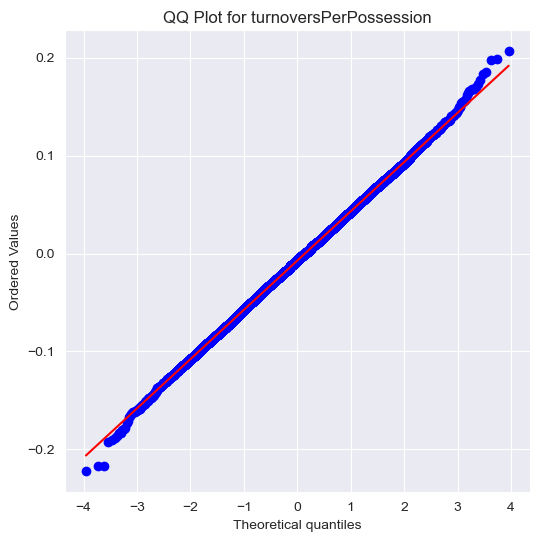

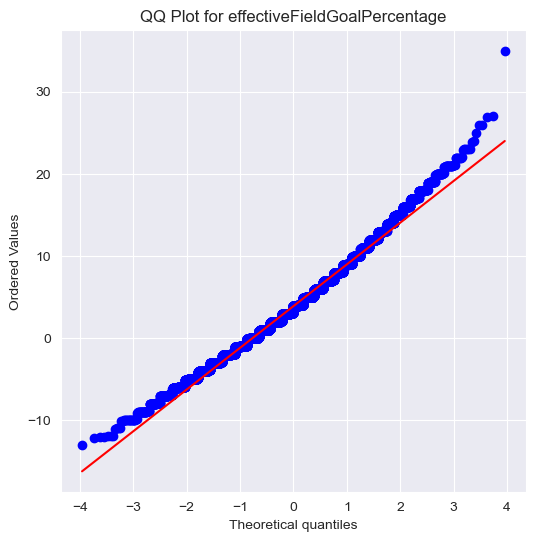

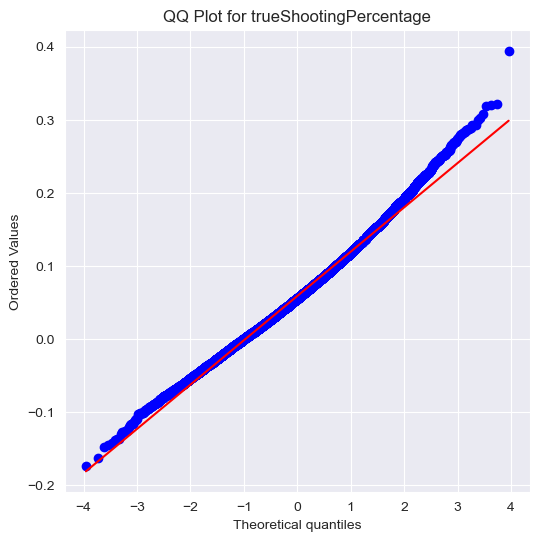

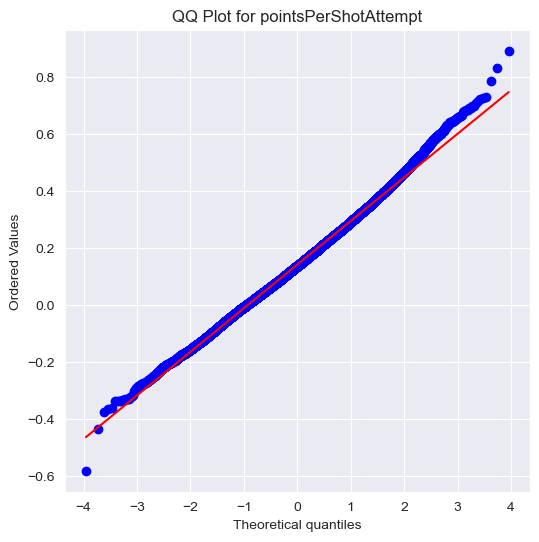

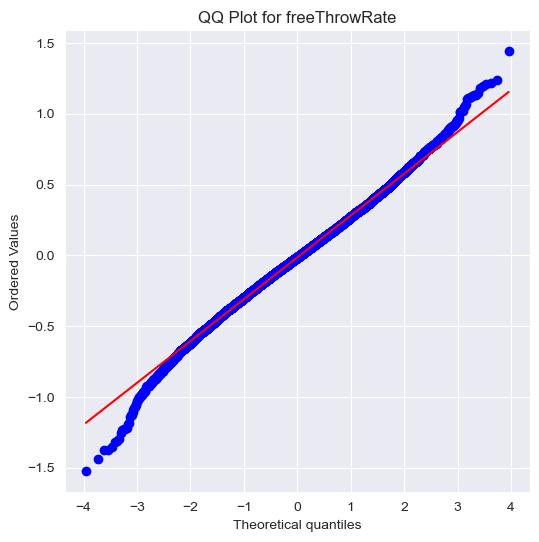

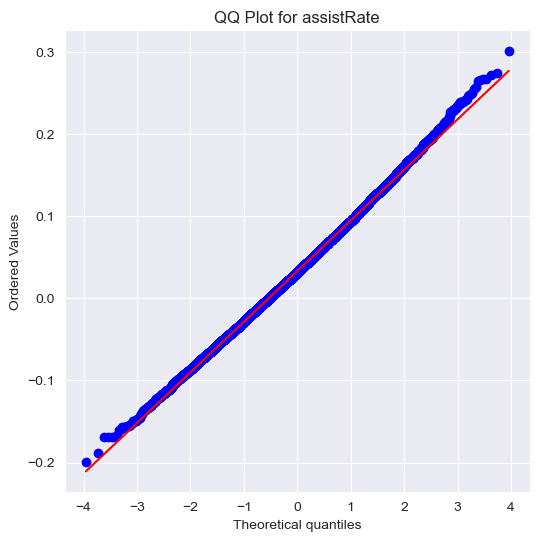

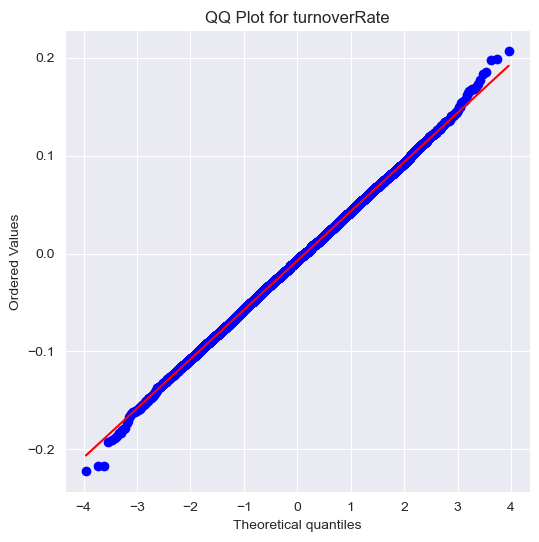

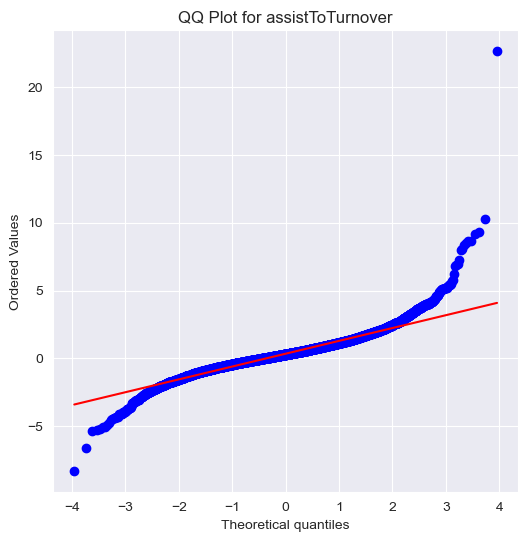

In [23]:
# Plot QQ Plots
for col in differences_2000.columns:
    plt.figure(figsize=(6, 6))
    stats.probplot(differences_2000[col], dist="norm", plot=plt)
    plt.title(f"QQ Plot for {col}")
    plt.show()

In [24]:
# Perform ttest of differences
from statsmodels.stats.multitest import multipletests
import pingouin as pg

results_2000 = []
for col in cols:
    diffs = differences_2000[col]

    if col == "teamScorePerPossession" or col == "assistToTurnover":
        res = pg.wilcoxon(diffs)
        statistic = res['W-val'].iloc[0]
        p_value = res['p-val'].iloc[0]
        effect_size = res['RBC'].iloc[0]
    else:
        statistic, p_value = stats.ttest_1samp(diffs, 0)
        effect_size = diffs.mean() / diffs.std(ddof=1)
    results_2000.append({
        'col': col,
        'mean_diff': diffs.mean(),
        'std_diff': diffs.std(ddof=1),
        't_statistic': statistic,
        'p_value': p_value,
        'effect_size': effect_size
    })

results_2000_df = pd.DataFrame(results_2000)

# Bonferri Correction
results_2000_df['corrected_p_value'] = multipletests(results_2000_df['p_value'], method='bonferroni')[1]
results_2000_df = results_2000_df.sort_values('effect_size', ascending=False).reset_index(drop=True)
results_2000_df

,col,mean_diff,std_diff,t_statistic,p_value,effect_size,corrected_p_value
0,teamScorePerPossession,0.119123,0.089084,9.004730e+05,0.000000e+00,0.989183,0.000000e+00
1,trueShootingPercentage,0.058930,0.060844,1.308334e+02,0.000000e+00,0.968552,0.000000e+00
2,pointsPerShotAttempt,0.142483,0.153230,1.256074e+02,0.000000e+00,0.929864,0.000000e+00
3,fieldGoalsPercentage,0.049374,0.059261,1.125443e+02,0.000000e+00,0.833158,0.000000e+00
4,fieldGoalsMadePerPossession,0.041360,0.051748,1.079648e+02,0.000000e+00,0.799257,0.000000e+00
5,effectiveFieldGoalPercentage,3.914645,5.106706,1.035493e+02,0.000000e+00,0.766569,0.000000e+00
6,reboundsDefensivePerPossession,0.039923,0.062149,8.677354e+01,0.000000e+00,0.642379,0.000000e+00
7,assistRate,0.033162,0.061645,7.266805e+01,0.000000e+00,0.537957,0.000000e+00
8,assistsPerPossession,0.033162,0.061645,7.266805e+01,0.000000e+00,0.537957,0.000000e+00
9,threePointersPercentage,0.061832,0.123279,6.775136e+01,0.000000e+00,0.501559,0.000000e+00


In [25]:
results_df

,col,mean_diff,std_diff,t_statistic,p_value,effect_size,corrected_p_value
0,teamScorePerPossession,0.117938,0.086893,5.746890e+06,0.000000e+00,0.988535,0.000000e+00
1,trueShootingPercentage,0.057481,0.060590,2.007481e+02,0.000000e+00,0.948689,0.000000e+00
2,pointsPerShotAttempt,0.146268,0.160501,1.928401e+02,0.000000e+00,0.911318,0.000000e+00
3,fieldGoalsPercentage,0.050014,0.061695,1.715419e+02,0.000000e+00,0.810668,0.000000e+00
4,fieldGoalsMadePerPossession,0.040324,0.053101,1.606879e+02,0.000000e+00,0.759374,0.000000e+00
5,effectiveFieldGoalPercentage,3.748978,5.198395,1.526058e+02,0.000000e+00,0.721180,0.000000e+00
6,reboundsDefensivePerPossession,0.039940,0.063379,1.333482e+02,0.000000e+00,0.630173,0.000000e+00
7,assistRate,0.036166,0.064055,1.194733e+02,0.000000e+00,0.564603,0.000000e+00
8,assistsPerPossession,0.036166,0.064055,1.194733e+02,0.000000e+00,0.564603,0.000000e+00
9,assistToTurnover,0.359089,0.906952,2.617085e+08,0.000000e+00,0.469612,0.000000e+00


Limiting ourselves to only games from 2000 and after, we do see a slight shift where three pointers are becoming more important than total rebounds.

# Collinearity

In [26]:
# Drop non-boxscore columns
box_score_2000 = team_statistics_df_2000.drop(columns=["gameId", "gameDate", "teamCity", "teamName", "teamId", "opponentTeamName", "opponentTeamCity", "opponentTeamId", "opponentTeamName"])
# Drop all normal boxscore columns in favor for PerPossession stats
box_score_2000 = box_score_2000.filter(regex=r'(PerPossession|Percentage)$')

corr_2000 = box_score_2000.corr().abs()
high_corr = (
    corr_2000.where(np.triu(np.ones(corr_2000.shape), k=1).astype(bool))
        .stack()
        .loc[lambda s: s > 0.75]
        .sort_values(ascending=False)
)
print(high_corr)

freeThrowsAttemptedPerPossession     freeThrowsMadePerPossession       0.923276
fieldGoalsPercentage                 trueShootingPercentage            0.910824
fieldGoalsMadePerPossession          effectiveFieldGoalPercentage      0.881216
teamScorePerPossession               trueShootingPercentage            0.873352
fieldGoalsPercentage                 fieldGoalsMadePerPossession       0.834562
teamScorePerPossession               fieldGoalsMadePerPossession       0.827767
threePointersAttemptedPerPossession  threePointersMadePerPossession    0.799212
fieldGoalsPercentage                 teamScorePerPossession            0.794746
reboundsDefensivePerPossession       reboundsTotalPerPossession        0.787838
teamScorePerPossession               effectiveFieldGoalPercentage      0.762173
fieldGoalsPercentage                 effectiveFieldGoalPercentage      0.760336
dtype: float64


In [28]:
box_score_2000 = box_score_2000.drop(columns=["freeThrowsMadePerPossession", "fieldGoalsPercentage", "fieldGoalsMadePerPossession", "teamScorePerPossession", "threePointersMadePerPossession", "reboundsTotalPerPossession"])

We decided to drop all the "MadePerPossession" columns because that metric essentially is explained already via Attempts/Possesion and Percentage, since thats the product of "MadePerPossession". We also decided to drop "ReboundsTotalPerPossession", because we have that metric via defensive and offensive rebounds. FieldGoalPercentage gets dropped because effectiveFieldGoalPercentage is an advanced version of it.

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calculate_vif(df):
    """Return a DataFrame with features and their VIFs."""
    X = df.copy()
    X['Intercept'] = 1.0
    vif_data = []
    for i, feature in enumerate(X.columns):
        if feature == 'Intercept':
            continue
        vif = variance_inflation_factor(X.values, i)
        vif_data.append({'feature': feature, 'VIF': vif})
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

def drop_high_vif(df, thresh=5.0):
    """
    Iteratively drop the variable with the highest VIF above threshold.

    Parameters
    ----------
    df : pd.DataFrame
        Numeric predictors only (no target variable).
    thresh : float
        VIF threshold; drop features until all VIFs <= thresh.

    Returns
    -------
    pd.DataFrame
        Subset of df with VIFs all below thresh.
    """
    df_current = df.copy()
    while True:
        vif_df = calculate_vif(df_current)
        max_vif = vif_df['VIF'].max()
        if max_vif <= thresh:
            break
        # identify and drop the worst
        worst_feature = vif_df.iloc[0]['feature']
        print(f"Dropping '{worst_feature}' with VIF={max_vif:.2f}")
        df_current = df_current.drop(columns=[worst_feature])
    return df_current

In [43]:
reduced_box_score_2000 = drop_high_vif(box_score_2000, thresh=15.0)
print(calculate_vif(reduced_box_score_2000))
features = reduced_box_score_2000.columns

divide by zero encountered in scalar divide


Dropping 'fieldGoalsAttemptedPerPossession' with VIF=inf
                                feature       VIF
12               trueShootingPercentage  8.311263
11         effectiveFieldGoalPercentage  4.707031
6      freeThrowsAttemptedPerPossession  2.326234
0               threePointersPercentage  1.941758
2                  assistsPerPossession  1.905328
8        reboundsOffensivePerPossession  1.701340
10               turnoversPerPossession  1.686784
5   threePointersAttemptedPerPossession  1.307431
1                  freeThrowsPercentage  1.267538
7        reboundsDefensivePerPossession  1.127662
4                   stealsPerPossession  1.083044
9            foulsPersonalPerPossession  1.081327
3                   blocksPerPossession  1.042397


We dropped "fieldGoalsAttemptedPerPossession" from performing VIF and always dropping the highest variable if its VIF is > 15

# Linear Regression

In [44]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = team_statistics_df_2000[features]
y = team_statistics_df_2000["win"]
features = X.columns

logit = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(cv=5, penalty='l1', solver='saga', scoring='roc_auc', max_iter=100000)
)
logit.fit(X, y)
coefs = logit.named_steps['logisticregressioncv'].coef_.ravel()
importance = pd.Series(abs(coefs), index=X.columns).sort_values(ascending=False)
print(importance)

trueShootingPercentage                 1.955254
reboundsDefensivePerPossession         1.633722
stealsPerPossession                    0.950421
reboundsOffensivePerPossession         0.677101
turnoversPerPossession                 0.572052
threePointersAttemptedPerPossession    0.384392
blocksPerPossession                    0.270780
freeThrowsAttemptedPerPossession       0.209236
foulsPersonalPerPossession             0.176028
threePointersPercentage                0.153402
assistsPerPossession                   0.112747
freeThrowsPercentage                   0.015451
effectiveFieldGoalPercentage           0.000000
dtype: float64


# Tree Based Model

In [45]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
rf = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)
perm = permutation_importance(rf, X_test, y_test, n_repeats=30, scoring='roc_auc')
importance = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print(importance)

reboundsDefensivePerPossession         0.152226
trueShootingPercentage                 0.105037
stealsPerPossession                    0.040011
freeThrowsAttemptedPerPossession       0.012626
effectiveFieldGoalPercentage           0.010766
reboundsOffensivePerPossession         0.010355
turnoversPerPossession                 0.005870
blocksPerPossession                    0.005711
threePointersAttemptedPerPossession    0.004964
threePointersPercentage                0.004336
assistsPerPossession                   0.002404
foulsPersonalPerPossession             0.001957
freeThrowsPercentage                   0.000630
dtype: float64


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


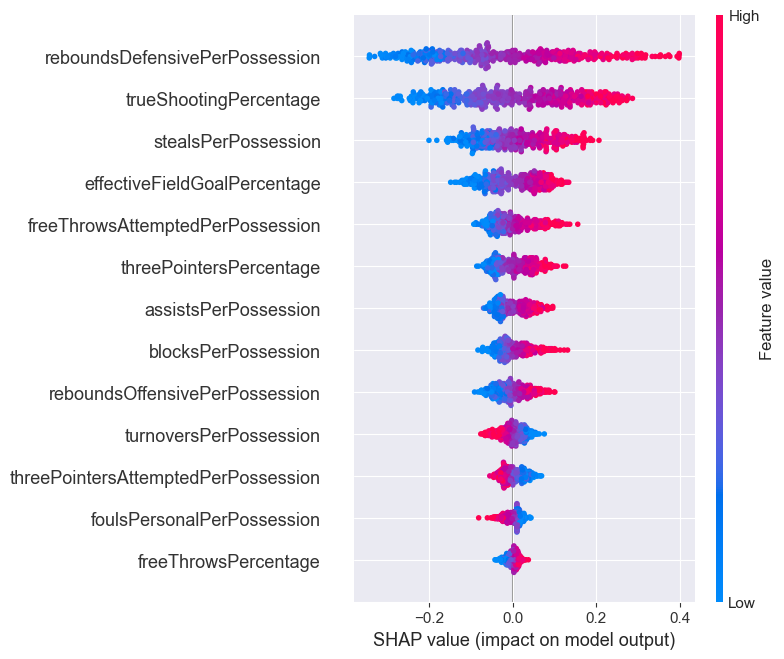

In [46]:
import shap
explainer = shap.TreeExplainer(rf)
# only explain 500 examples instead of, say, 10,000
X_small = X_test.sample(n=500, random_state=42)
shap_vals = explainer.shap_values(X_small)
shap.summary_plot(shap_vals[1], X_small)   # class=1 = win

# LDA

LDA coefficients (sorted by magnitude):
stealsPerPossession                    34.382202
reboundsDefensivePerPossession         32.283414
trueShootingPercentage                 31.669527
reboundsOffensivePerPossession         18.520528
turnoversPerPossession                 15.891385
blocksPerPossession                    11.784716
foulsPersonalPerPossession              5.818909
threePointersAttemptedPerPossession     5.059705
freeThrowsAttemptedPerPossession        3.876172
assistsPerPossession                    2.646177
threePointersPercentage                 1.760110
freeThrowsPercentage                    0.563117
effectiveFieldGoalPercentage            0.006265
dtype: float64


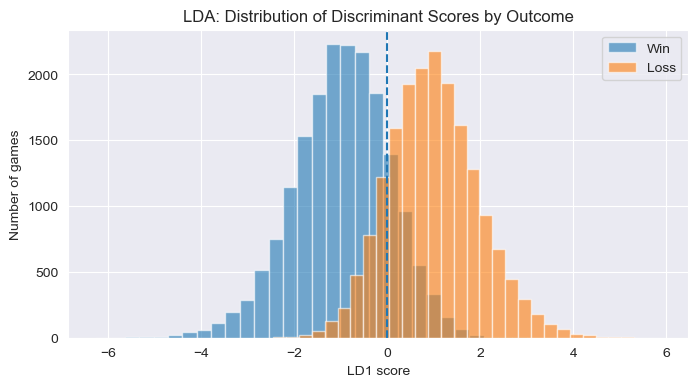

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X, y)
coef = pd.Series(lda.coef_[0], index=features)
print("LDA coefficients (sorted by magnitude):")
print(coef.abs().sort_values(ascending=False))

plt.figure(figsize=(8,4))
plt.hist(X_lda[y==1], bins=30, alpha=0.6, label="Win")
plt.hist(X_lda[y==0], bins=30, alpha=0.6, label="Loss")
plt.axvline(0, linestyle="--")             # cutoff at score=0
plt.legend()
plt.title("LDA: Distribution of Discriminant Scores by Outcome")
plt.xlabel("LD1 score")
plt.ylabel("Number of games")
plt.show()

# Conclusions over all models


After rescaling and averaging each feature over all models, it seems that TrueShootingPercentage, StealsPerPossession and reboundsDefensivePerPossession are the most important metrics on average. TrueShootingPercentage makes sense since it combines all scoring into one (2P, 3P and FT), StealsPerPossession and reboundsDefensivePerPossession explain the defense of the team, since steals lead to turnovers and less possessions for the opposing teams to score, and defensive rebounds can be thought of that your team will have more if the opposing team shoots poorly. Interestingly, assists do not quite matter as much.



In [48]:
from sklearn.preprocessing import MinMaxScaler


logit_feat = pd.Series(np.abs(coefs), index=features, name='logit_coef')
rf_feat = pd.Series(perm.importances_mean, index=features, name='rf_perm')
shap_feat = pd.Series(np.abs(shap_vals[1]).mean(axis=0), index=features, name='shap_meanabs')
lda_feat = pd.Series(np.abs(lda.coef_[0]), index=features, name='lda_coef')

feature_importance = pd.concat([logit_feat, rf_feat, shap_feat, lda_feat], axis=1)

scaler = MinMaxScaler()
feature_importance[:] = scaler.fit_transform(feature_importance)
feature_importance['avg'] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values('avg', ascending=False)
print(feature_importance)

                                     logit_coef   rf_perm  shap_meanabs  \
reboundsDefensivePerPossession         0.835555  1.000000      1.000000   
trueShootingPercentage                 1.000000  0.688720      0.844015   
stealsPerPossession                    0.486086  0.259776      0.438505   
reboundsOffensivePerPossession         0.346298  0.064148      0.149737   
turnoversPerPossession                 0.292572  0.034567      0.091186   
blocksPerPossession                    0.138488  0.033518      0.157567   
freeThrowsAttemptedPerPossession       0.107012  0.079131      0.224752   
threePointersAttemptedPerPossession    0.196594  0.028586      0.078253   
effectiveFieldGoalPercentage           0.000000  0.066863      0.334625   
threePointersPercentage                0.078456  0.024446      0.206702   
assistsPerPossession                   0.057664  0.011704      0.163776   
foulsPersonalPerPossession             0.090028  0.008751      0.039899   
freeThrowsPercentage     

In [50]:
# Save features into csv
features = features.tolist()
cols = ["gameId", "gameDate", "teamCity", "teamName", "opponentTeamCity", "opponentTeamName", "home", "win", "teamScore", "opponentScore"] + features
important_features_df = team_statistics_df[cols]
important_features_df.to_csv(os.path.join(DATA_PATH, "important_features.csv"), index=False)